# Advanced Regression Techniques for Housing Price Prediction

## Executive Summary

This project applies a comprehensive suite of modern regression techniques to predict housing prices in King County, Washington. By systematically comparing multiple modeling approaches including linear methods (best subset selection, stepwise selection, ridge and lasso regression) and tree-based methods (single regression trees, bagging, random forests, and gradient boosting), we identify optimal predictive models for real estate valuation.

The analysis demonstrates that ensemble tree-based methods, particularly gradient boosting, significantly outperform traditional linear approaches for this dataset. The project showcases practical implementation of machine learning methods for regression problems while providing insights into the key factors driving housing prices in the Seattle metropolitan area.

## Table of Contents
1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
3. [Linear Model Approaches](#linear-model-approaches)
4. [Tree-based Approaches](#tree-based-approaches)
5. [Conclusion](#conclusion)

## 1. Introduction

### 1.1 Problem Statement

Accurate housing price prediction serves crucial purposes for both sellers and buyers in the real estate market:

- For sellers, accurate pricing prevents undervaluing (losing potential profit) or overvaluing (deterring potential buyers)
- For buyers, price prediction helps identify good investment opportunities and avoid overpaying

This project utilizes the King County Housing Dataset (May 2014 to May 2015) to develop and compare multiple regression models for predicting home prices in the Seattle area.

### 1.2 Dataset Overview

The dataset contains 21,613 housing records with 21 features describing various property attributes:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ParameterGrid
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeRegressor, plot_tree
from plotnine import *
from dfply import *
import folium

# Import data from GitHub
url = "https://raw.githubusercontent.com/Juancorreav/advanced-regression-housing-prices/main/data/kc_house_data.csv"
house_data = pd.read_csv(url)

# Overview of data
house_data.info()

# Check for missing data
print('Number of missing data:', house_data.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

The dataset is complete with no missing values, which simplifies our preprocessing requirements.

### 1.3 Methodology Overview

This analysis employs a range of statistical and machine learning techniques:

1. **Data Exploration**: Visualizing and understanding distributions, relationships, and potential patterns
2. **Linear Models**:
   - Best subset selection
   - Forward and backward stepwise selection
   - Ridge and lasso regression
   - Principal Components Regression (PCR)
   - Partial Least Squares (PLS)
3. **Tree-based Models**:
   - Single regression trees
   - Bagging
   - Random forests
   - Gradient boosting

Each approach will be evaluated using k-fold cross-validation and test set performance, with mean squared error (MSE) as the primary evaluation metric.

## 2. Exploratory Data Analysis

### 2.1 Price Distribution

Understanding the distribution of our target variable (house prices) is essential before building predictive models:

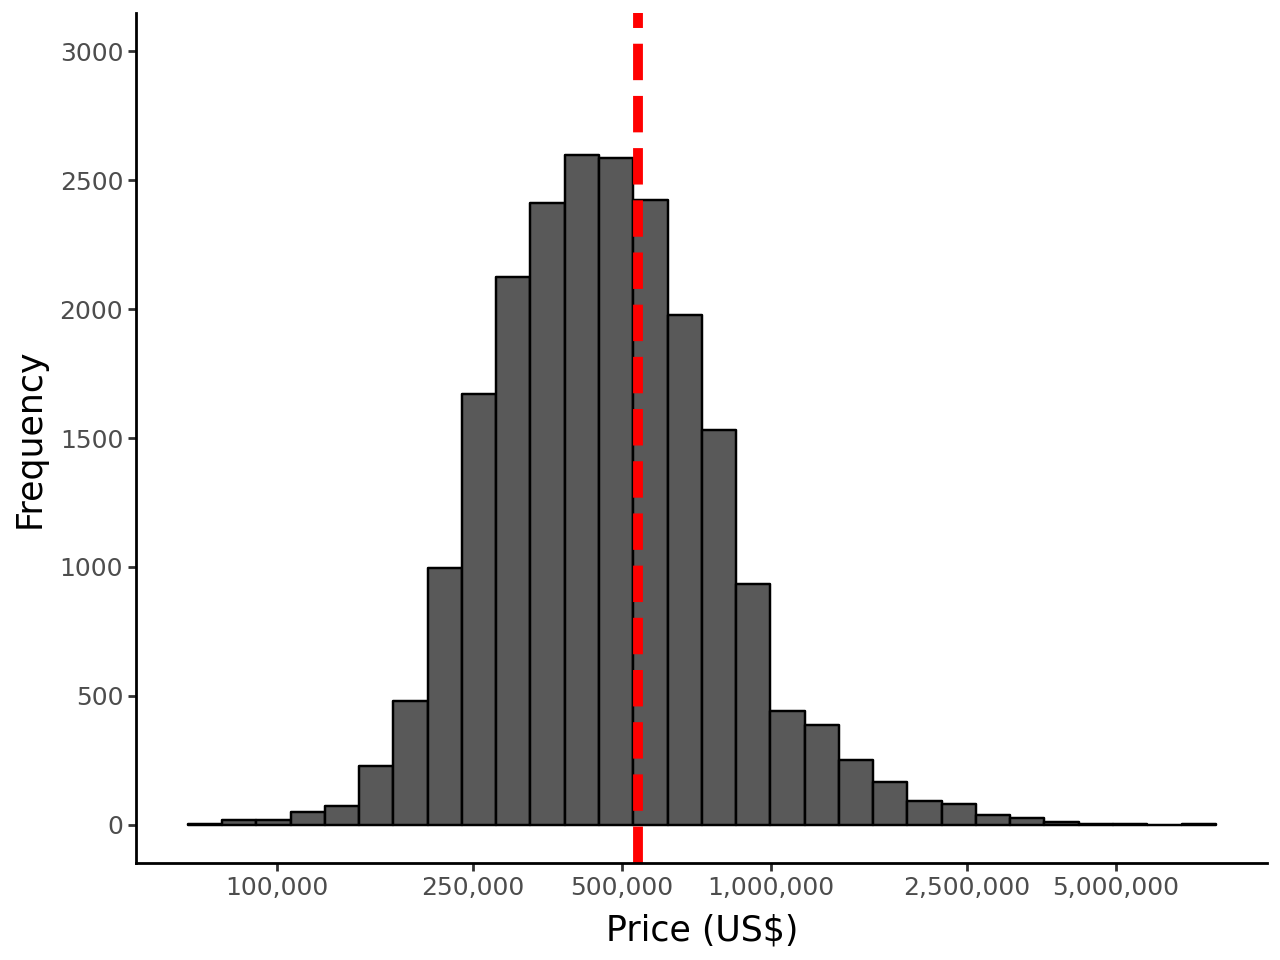

In [ ]:
price_plot_theme = theme(axis_title = element_text(size = 12.5),
                         axis_text = element_text(size = 9))

price_plot = (ggplot(data = house_data, mapping = aes(x = 'price')) +
  geom_histogram(color = 'black', bins = 30) +
  geom_vline(xintercept = house_data['price'].mean(), linetype = 'dashed',
             color = 'red', size = 2) +
  theme_classic() +
  xlab('Price (US$)') +
  ylab('Frequency') +
  price_plot_theme +
  scale_x_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000',
                                        '5,000,000'])) +
  scale_y_continuous(breaks = np.array(range(0, 3500, 500)),
                     labels = np.array(range(0, 3500, 500)),
                     limits = np.array([0, 3000]))
)
price_plot

The price distribution is right-skewed, with a mean of $540,088 (indicated by the red line). Most properties in the dataset are priced below $1 million, with relatively few high-value properties above this threshold. This positive skew suggests that logarithmic transformation of the price variable may be appropriate for modeling to normalize the distribution.

### 2.2 Housing Age and Price Relationship

Next, we examine how construction year relates to housing volume and current prices:

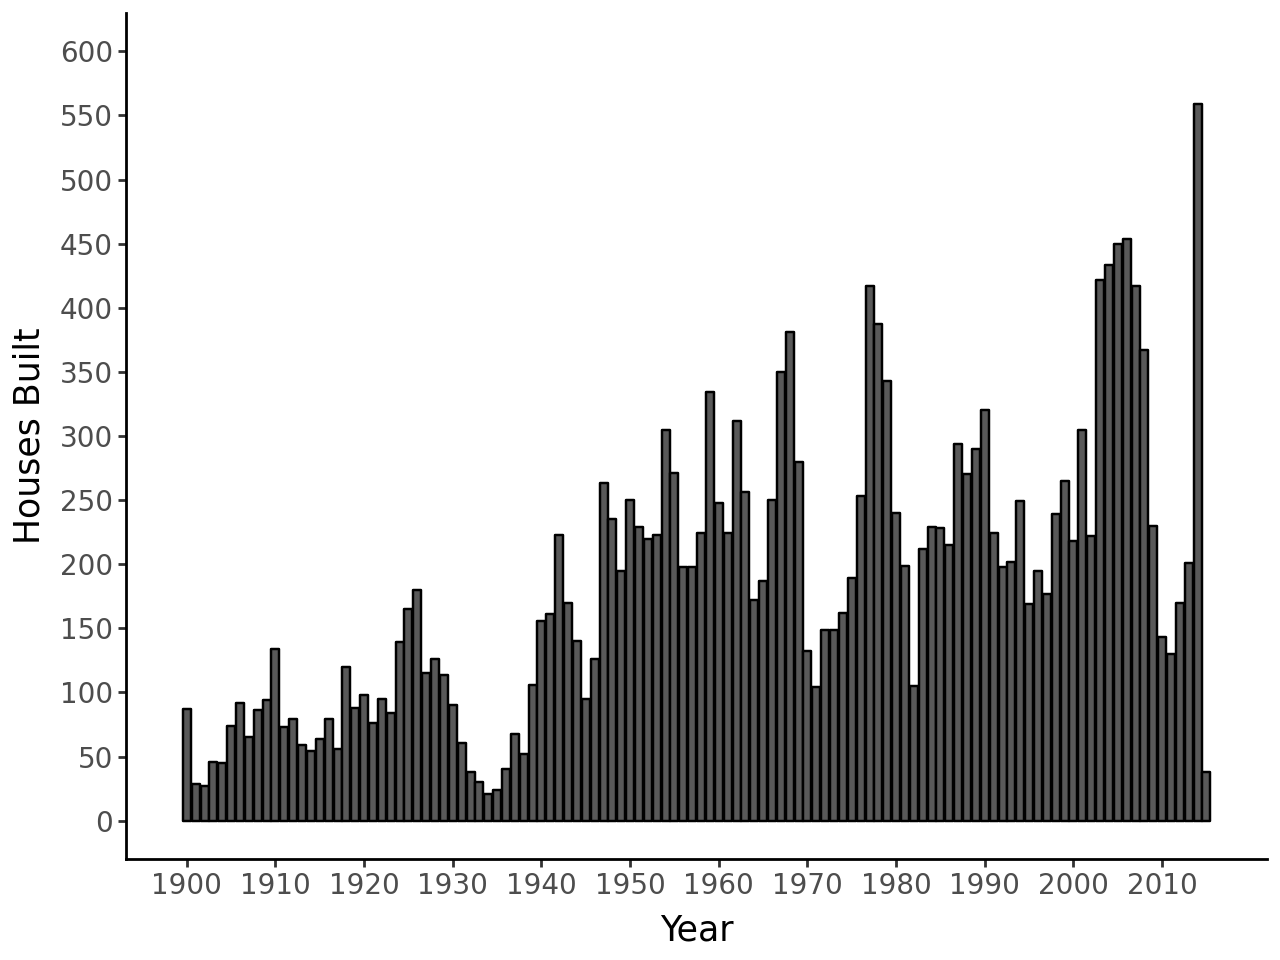

In [ ]:
# Houses built over time
yearBuilt = (house_data >>
  group_by(X.yr_built) >>
  summarize(rows = n(X.yr_built))
)

yearBuilt_plot_theme = theme(axis_title = element_text(size = 12.5),
                             axis_text = element_text(size = 10))
yearBuilt_plot = (ggplot(data = yearBuilt,
                         mapping = aes(x = 'yr_built', y = 'rows')) +
  geom_bar(stat = 'identity', color = 'black') +
  theme_classic() +
  xlab('Year') +
  ylab('Houses Built') +
  yearBuilt_plot_theme +
  scale_x_continuous(breaks = np.array(range(1900, 2020, 10)),
                     labels = np.array(range(1900, 2020, 10)),
                     limits = np.array([1899, 2016])) +
  scale_y_continuous(breaks = np.array(range(0, 650, 50)),
                     labels = np.array(range(0, 650, 50)),
                     limits = np.array([0, 600]))
)
yearBuilt_plot

The historical construction data reveals interesting patterns:
- A general upward trend in housing construction over time
- Notable declines during the 1930s (likely due to the Great Depression)
- A second significant decline in the 1970s (possibly related to economic factors including the 1973 oil crisis)

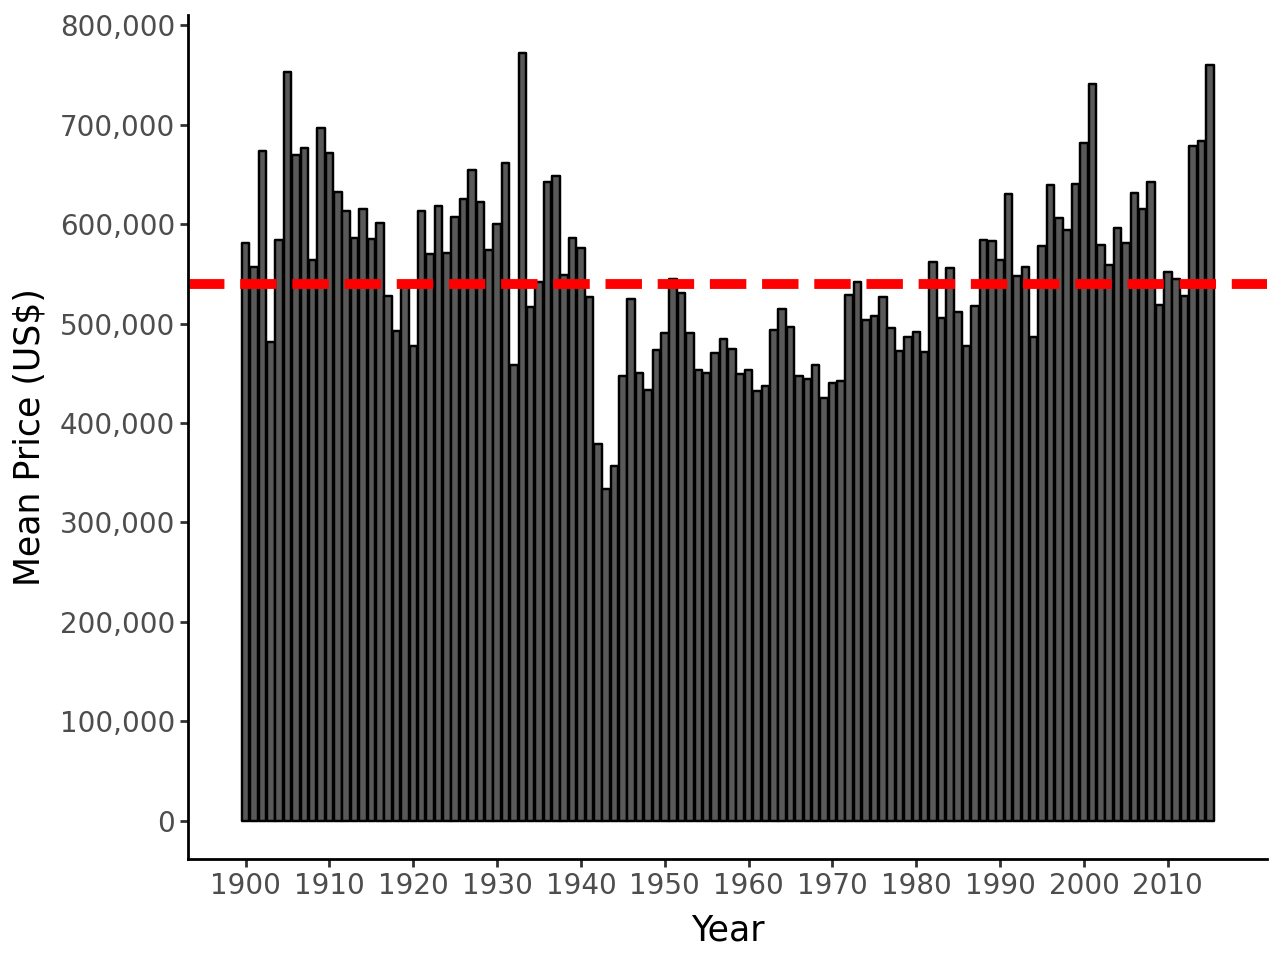

In [ ]:
# Mean price of house per year built
yearBuilt_price = (house_data >>
  group_by(X.yr_built) >>
  summarize(mean_price = mean(X.price)) >>
  arrange(X.yr_built)
)

yearBuilt_price_plot_theme = theme(axis_title = element_text(size = 12.5),
                                   axis_text = element_text(size = 10))
yearBuilt_price_plot = (ggplot(data = yearBuilt_price,
                               mapping = aes(x = 'yr_built',
                                             y = 'mean_price')) +
  geom_bar(stat = 'identity', color = 'black') +
  theme_classic() +
  xlab('Year') +
  ylab('Mean Price (US$)') +
  yearBuilt_price_plot_theme +
  geom_hline(yintercept = house_data['price'].mean(),
             linetype = 'dashed', color = 'red', size = 2) +
  scale_x_continuous(breaks = np.array(range(1900, 2020, 10)),
                     labels = np.array(range(1900, 2020, 10)),
                     limits = np.array([1899, 2016])) +
  scale_y_continuous(breaks = np.array(range(0, 900000, 100000)),
                     labels = np.array(['0', '100,000', '200,000', '300,000',
                                        '400,000', '500,000', '600,000',
                                        '700,000', '800,000']))
)
yearBuilt_price_plot

The relationship between construction year and current property value shows a distinctive pattern:
- Houses built before 1940 and after 1980 tend to command above-average prices
- Properties built between 1940-1980 typically sell below the average price
- This "U-shaped" relationship may indicate that older homes possess historical charm or character that increases their value, while newest homes offer modern amenities and designs

### 2.3 Neighborhood Effects

The dataset includes variables describing characteristics of the 15 nearest neighboring properties, allowing us to examine how neighborhood context influences property values:

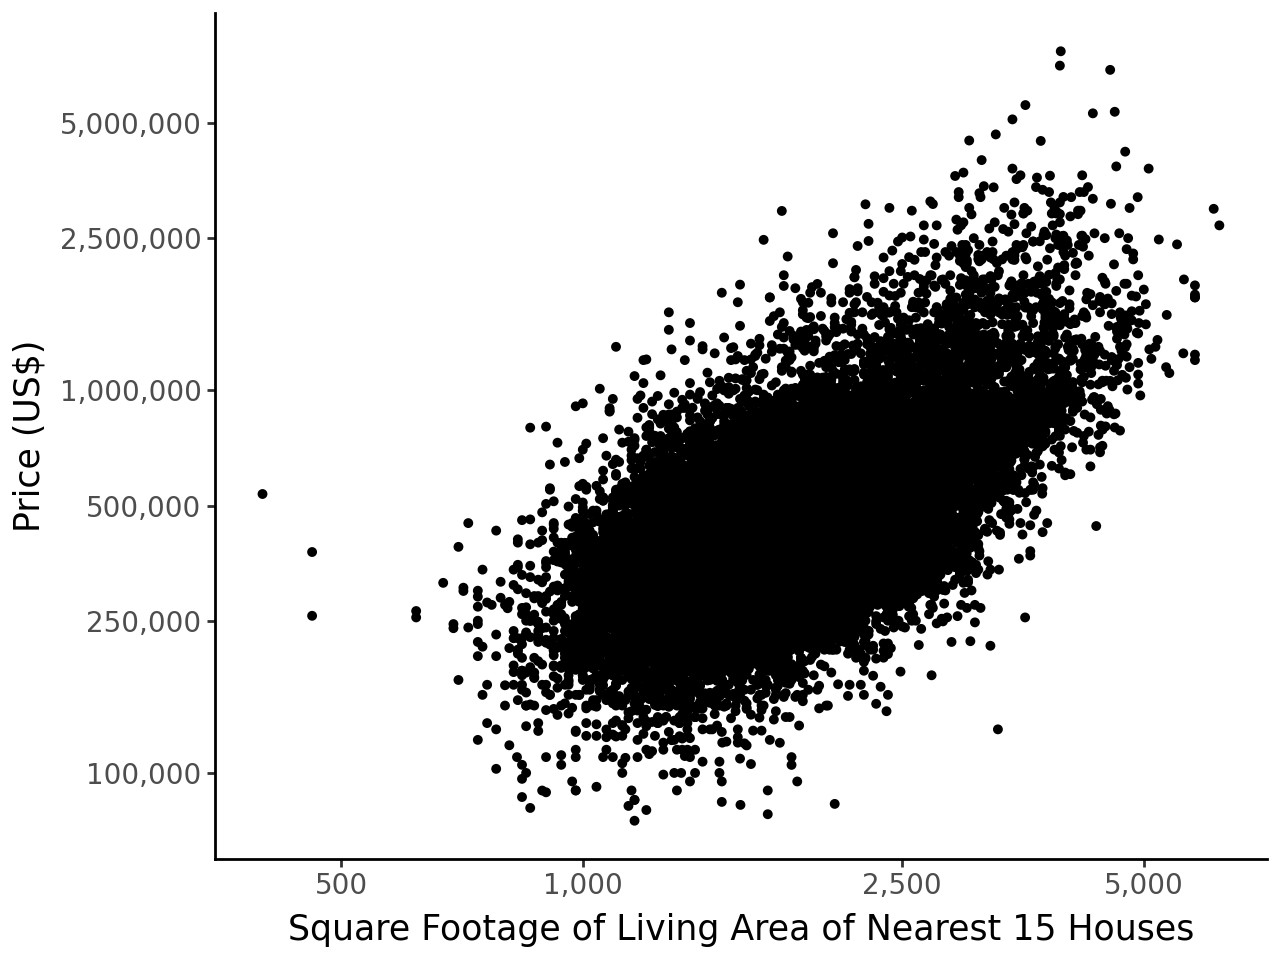

In [ ]:
# Square footage of living area of surrounding 15 houses
sqft_liv15_plot_theme = theme(axis_title = element_text(size = 12.5),
                              axis_text = element_text(size = 10))
sqft_liv15_plot = (ggplot(data = house_data,
                          mapping = aes(x = 'sqft_living15', y = 'price')) +
  geom_point(size = 1) +
  theme_classic() +
  xlab('Square Footage of Living Area of Nearest 15 Houses') +
  ylab('Price (US$)') +
  sqft_liv15_plot_theme +
  scale_x_continuous(trans = 'log',
                     breaks = np.array([500, 1000, 2500, 5000]),
                     labels = np.array(['500', '1,000', '2,500', '5,000'])) +
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
)
sqft_liv15_plot

There is a strong positive correlation between a property's price and the average living area of surrounding homes. This suggests that neighborhood composition is an important price determinant, as properties tend to be more valuable when surrounded by larger homes.

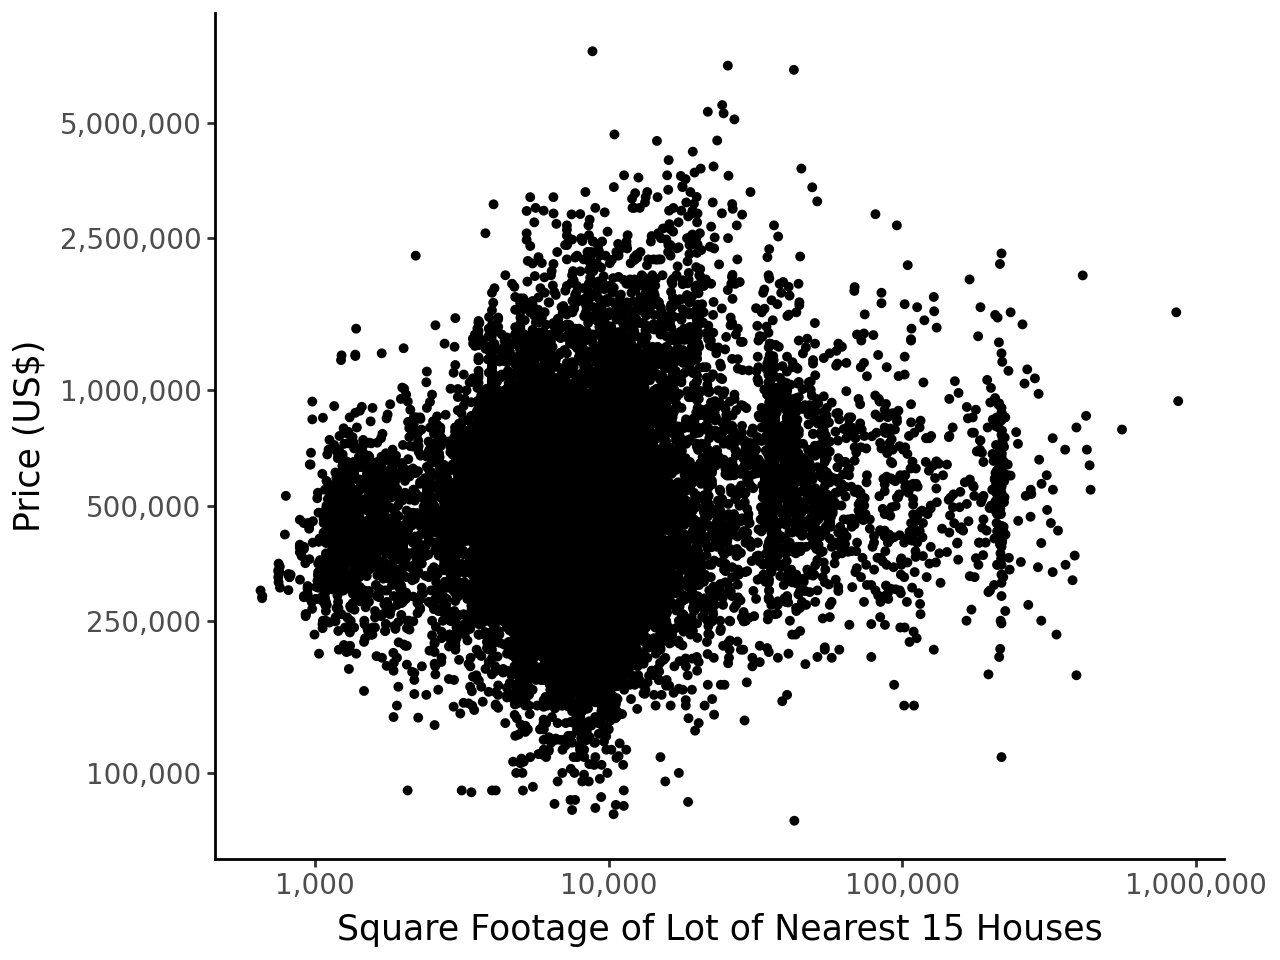

In [ ]:
# Square footage of lot of surrounding 15 houses
sqft_lot15_plot_theme = theme(axis_title = element_text(size = 12.5),
                              axis_text = element_text(size = 10))
sqft_lot15_plot = (ggplot(data = house_data,
                          mapping = aes(x = 'sqft_lot15', y = 'price')) +
  geom_point(size = 1) +
  theme_classic() +
  xlab('Square Footage of Lot of Nearest 15 Houses') +
  ylab('Price (US$)') +
  sqft_lot15_plot_theme +
  scale_x_continuous(trans = 'log',
                     breaks = np.array([1000, 10000, 100000, 1000000]),
                     labels = np.array(['1,000', '10,000', '100,000',
                                        '1,000,000'])) +
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
)
sqft_lot15_plot

Interestingly, while neighboring living area size shows strong correlation with price, the average lot size of neighboring properties shows minimal relationship with a home's value. This suggests that in the Seattle market, the size of nearby homes may be more important for determining value than the size of surrounding lots.

### 2.4 Property Quality Factors

Several variables in the dataset assess different dimensions of property quality:

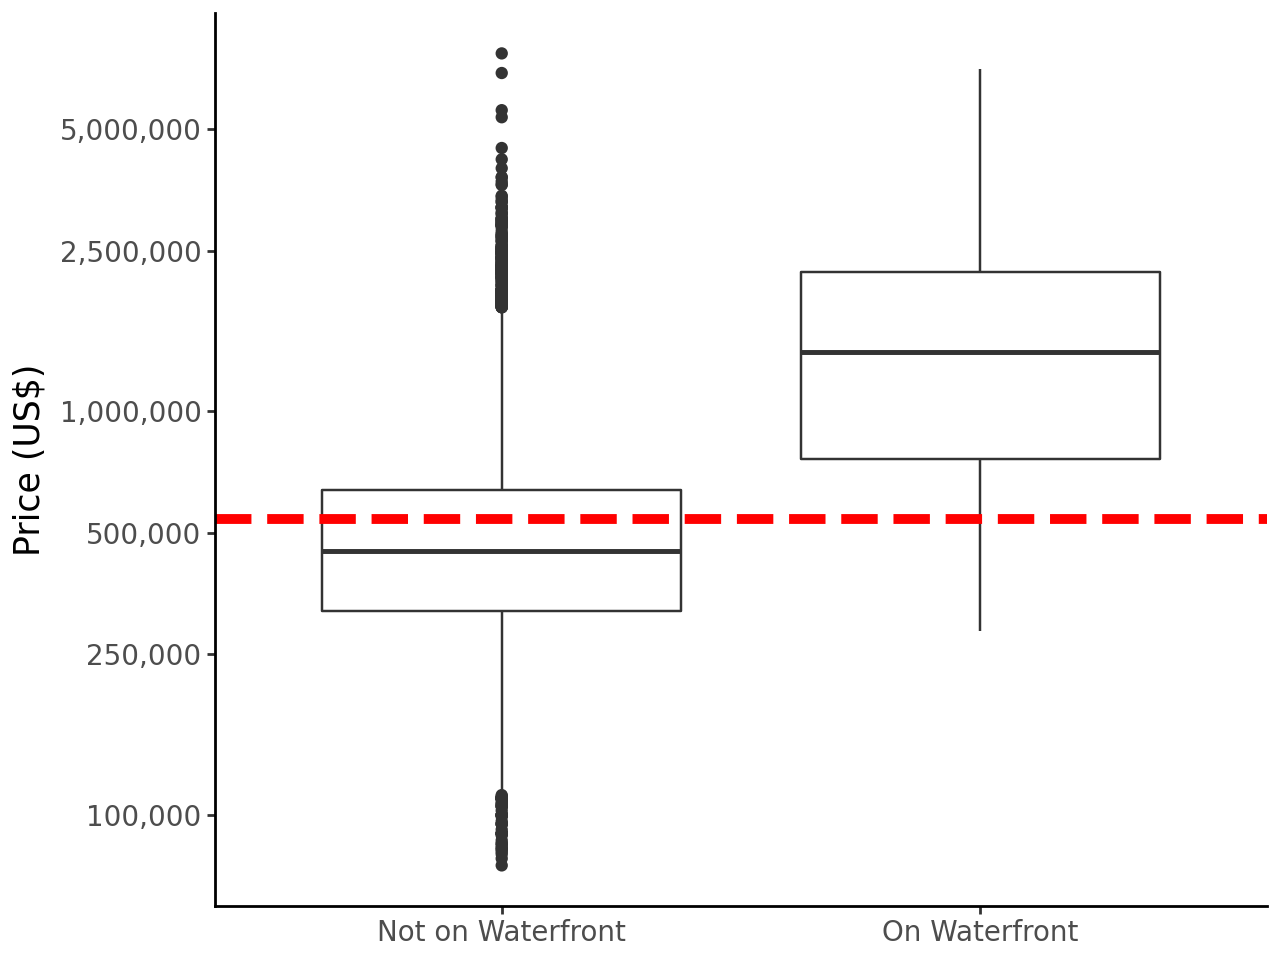

In [ ]:
# Waterfront
wft_plot_theme = theme(axis_title=element_text(size=12.5),
                       axis_text=element_text(size=10))

wft_plot = (
    ggplot(data=house_data,
           mapping=aes(x=house_data['waterfront'].astype('category'),
                       y='price')) +
    geom_boxplot() +
    geom_hline(yintercept=house_data['price'].mean(),
               linetype='dashed', color='red', size=2) +
    theme_classic() +
    xlab('') +
    ylab('Price (US$)') +
    wft_plot_theme +
    scale_x_discrete(labels=['Not on Waterfront', 'On Waterfront']) +
    scale_y_continuous(trans='log',
                       breaks=[100000, 250000, 500000, 1000000, 2500000, 5000000],
                       labels=['100,000', '250,000', '500,000', '1,000,000', '2,500,000', '5,000,000'])
)
wft_plot

Waterfront properties show higher median prices, but the effect is less pronounced than might be expected. This could be due to the relatively small number of waterfront properties in the dataset or other factors influencing these properties.

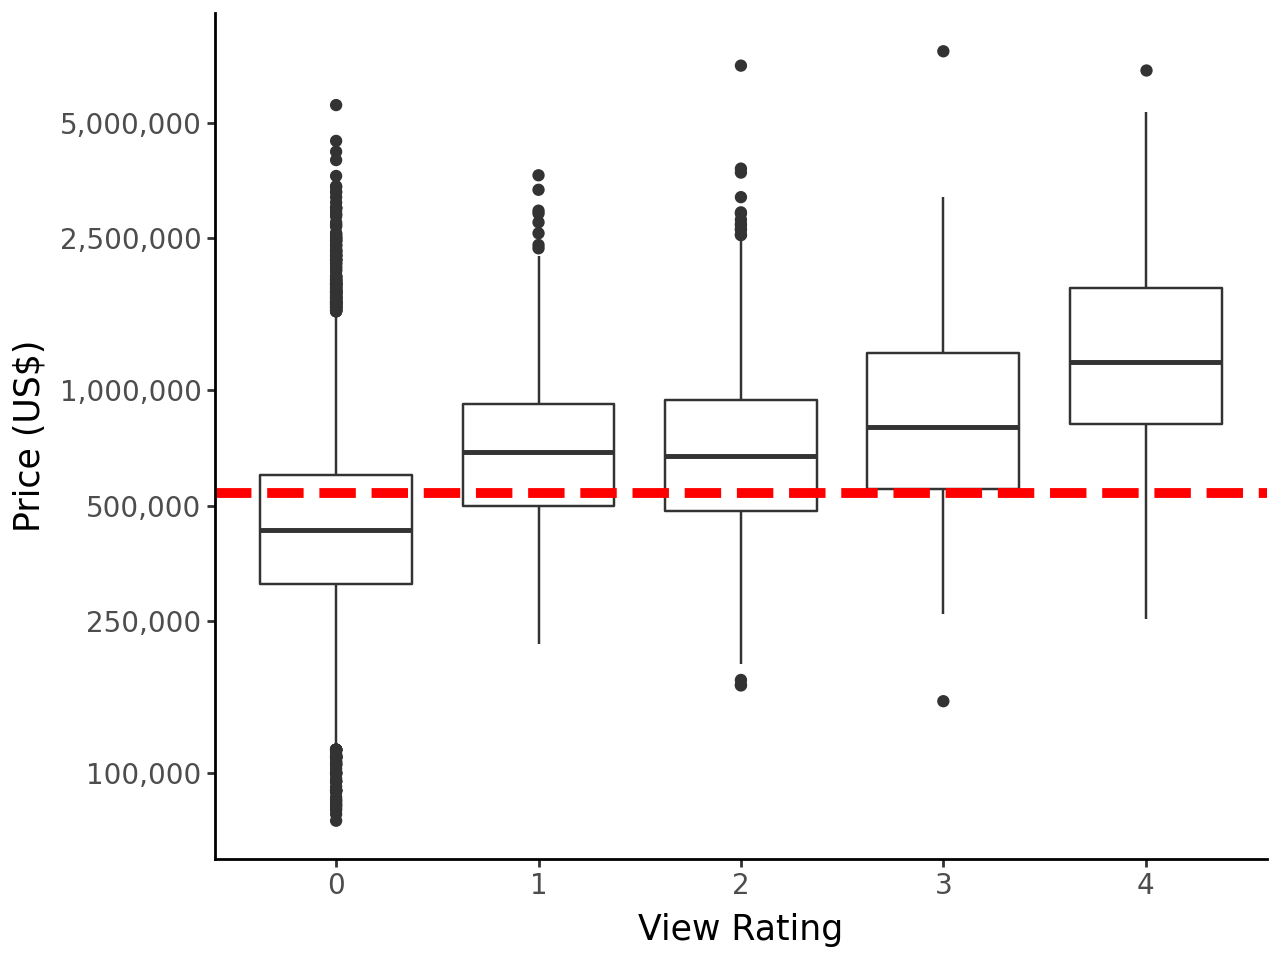

In [ ]:
# View
view_plot_theme = theme(axis_title = element_text(size = 12.5),
                        axis_text = element_text(size = 10))
view_plot = (ggplot(data = house_data,
                    mapping = aes(x = house_data['view'].astype('category'),
                                  y = 'price')) +
  geom_boxplot() +
  geom_hline(yintercept = house_data['price'].mean(),
             linetype = 'dashed', color = 'red', size = 2) +
  theme_classic() +
  xlab('View Rating') +
  ylab('Price (US$)') +
  view_plot_theme +
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
)
view_plot

View quality (rated 0-4) shows a modest positive relationship with property value, though the effect appears less substantial than other factors.

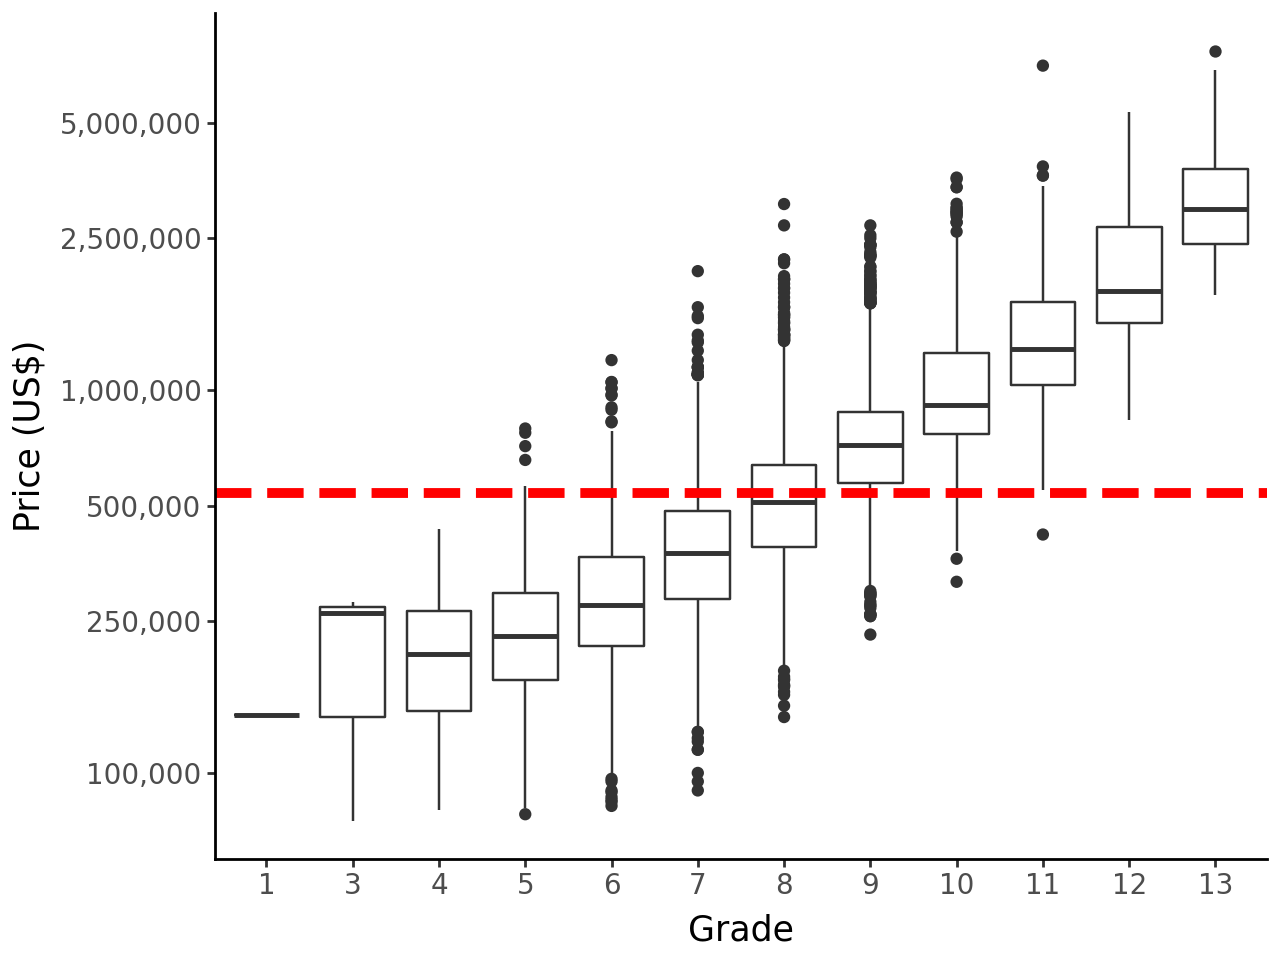

In [ ]:
# Grade
grd_plot_theme = theme(axis_title = element_text(size = 12.5),
                       axis_text = element_text(size = 10))
grd_plot = (ggplot(data = house_data,
                   mapping = aes(x = house_data['grade'].astype('category'),
                                 y = 'price')) +
  geom_boxplot() +
  geom_hline(yintercept = house_data['price'].mean(),
             linetype = 'dashed', color = 'red', size = 2) +
  theme_classic() +
  xlab('Grade') +
  ylab('Price (US$)') +
  grd_plot_theme +
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
)
grd_plot

Grade (1-13) shows a strong relationship with price. This variable, which assesses construction quality and design, demonstrates a clear positive correlation with property value. Even the lowest-priced homes with high grades (12-13) are more expensive than the highest-priced homes with low grades (1-4).

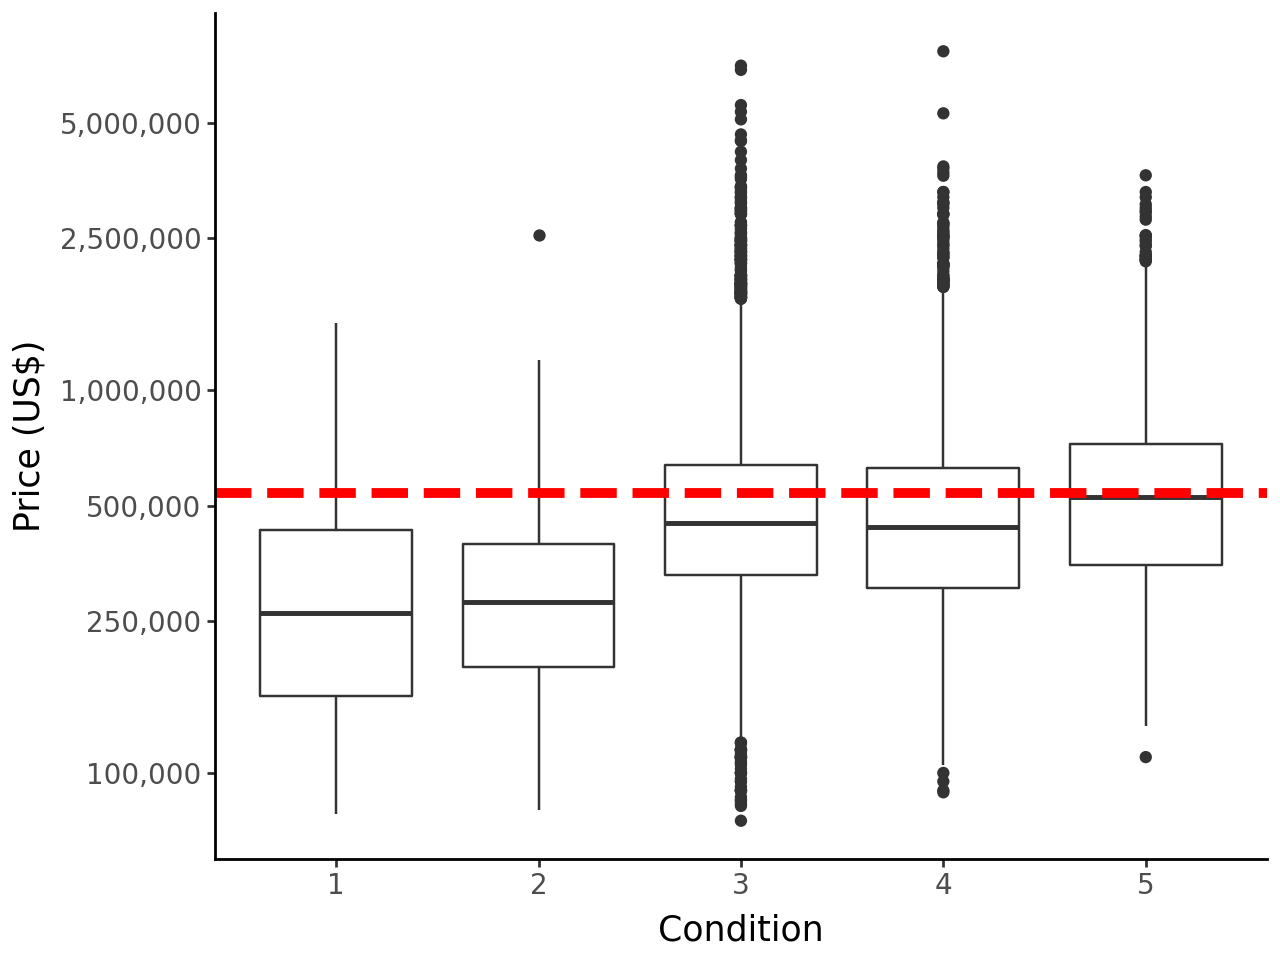

In [ ]:
# Condition
cond_plot_theme = theme(axis_title = element_text(size = 12.5),
                        axis_text = element_text(size = 10))
cond_plot = (ggplot(data = house_data,
                    mapping = aes(x = house_data['condition'].astype('category'),
                                  y = 'price')) +
  geom_boxplot() +
  geom_hline(yintercept = house_data['price'].mean(),
             linetype = 'dashed', color = 'red', size = 2) +
  theme_classic() +
  xlab('Condition') +
  ylab('Price (US$)') +
  cond_plot_theme +
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
)
cond_plot

Property condition (1-5) shows a modest positive relationship with price, though the highest condition category (5) does not necessarily correlate with the highest prices. This suggests that while condition matters, other factors like location or size may have greater influence on property value.

### 2.5 Property Size Metrics

Next, we examine how various size metrics correlate with property values:

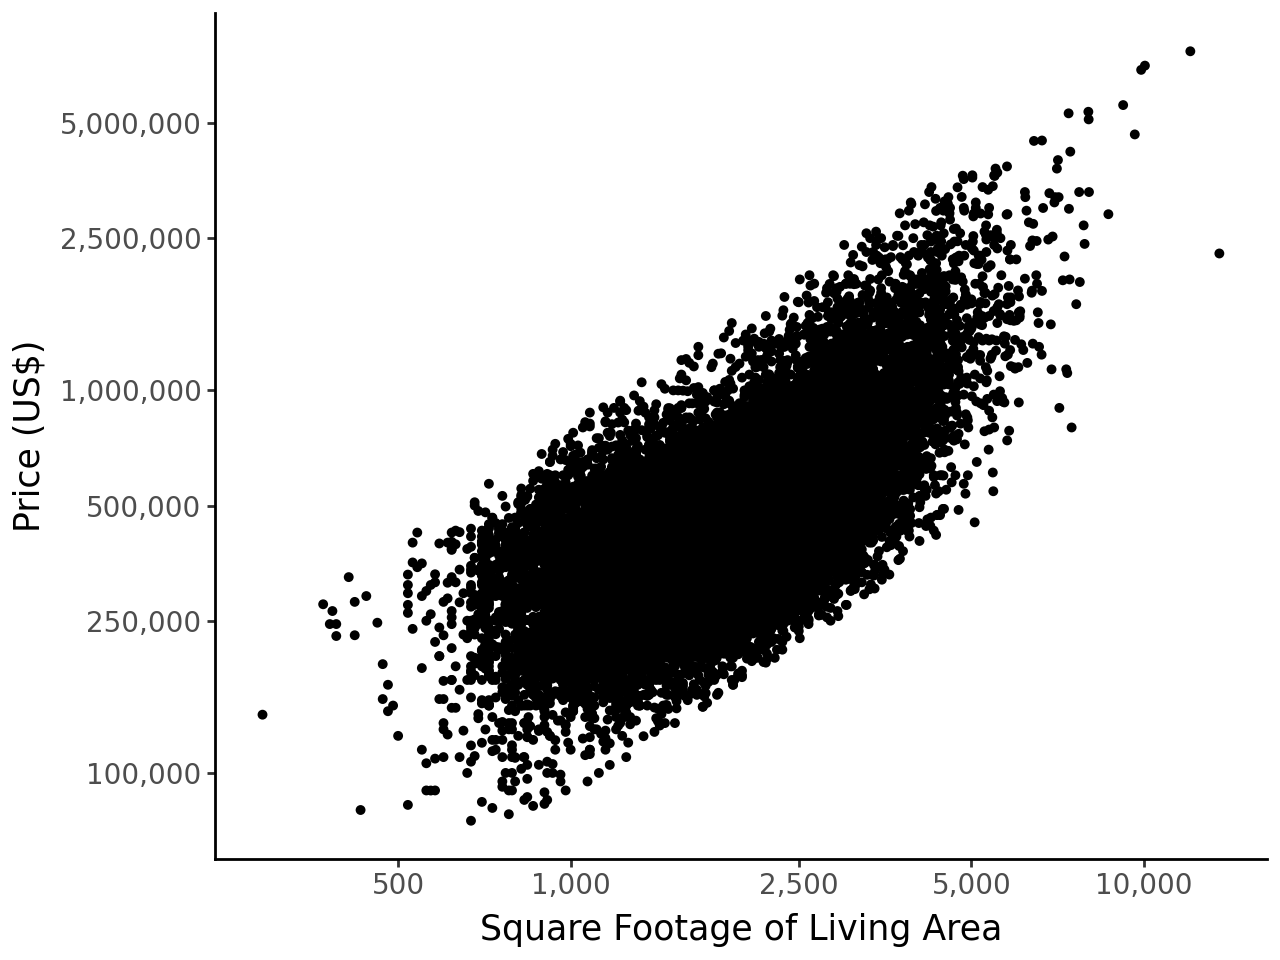

In [ ]:
# Square footage of interior living space
sqft_liv_plot_theme = theme(axis_title = element_text(size = 12.5),
                            axis_text = element_text(size = 10))
sqft_liv_plot = (ggplot(data = house_data,
                        mapping = aes(x = 'sqft_living', y = 'price')) +
  geom_point(size = 1) +
  theme_classic() +
  xlab('Square Footage of Living Area') +
  ylab('Price (US$)') +
  sqft_liv_plot_theme +
  scale_x_continuous(trans = 'log',
                     breaks = np.array([500, 1000, 2500, 5000, 10000]),
                     labels = np.array(['500', '1,000', '2,500', '5,000',
                                        '10,000'])) +
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
)
sqft_liv_plot

A strong positive correlation exists between living area square footage and property price, confirming that home size is a primary determinant of value.

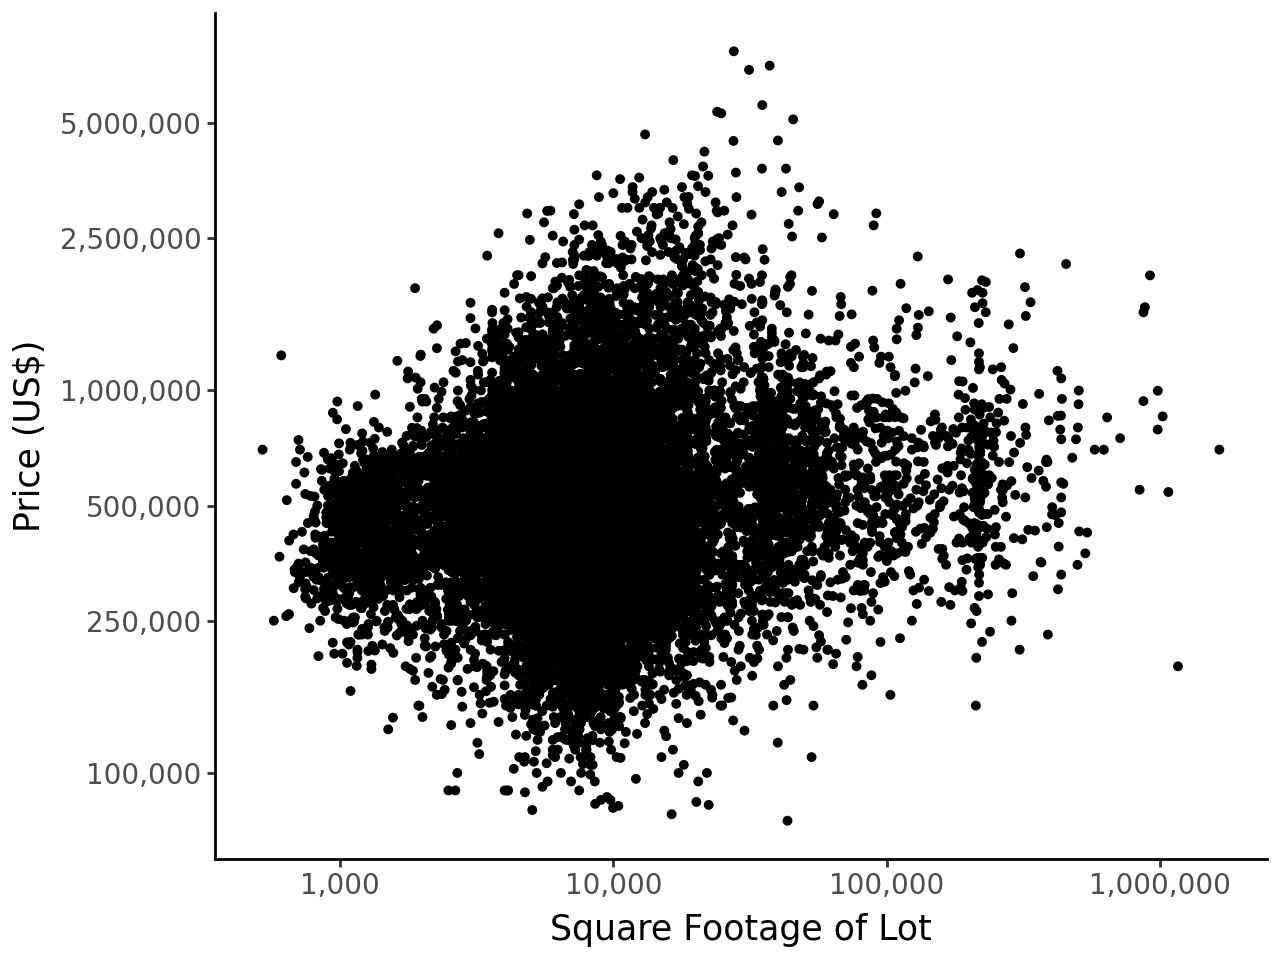

In [ ]:
# Square footage of land space
sqft_lot_plot_theme = theme(axis_title = element_text(size = 12.5),
                            axis_text = element_text(size = 10))
sqft_lot_plot = (ggplot(data = house_data,
                        mapping = aes(x = 'sqft_lot', y = 'price')) +
  geom_point(size = 1) +
  theme_classic() +
  xlab('Square Footage of Lot') +
  ylab('Price (US$)') +
  sqft_lot_plot_theme +
  scale_x_continuous(trans = 'log',
                     breaks = np.array([1000, 10000, 100000, 1000000]),
                     labels = np.array(['1,000', '10,000', '100,000',
                                        '1,000,000'])) +
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
)
sqft_lot_plot

In contrast to living area, lot size shows a much weaker relationship with property price. This suggests that in this urban/suburban market, the size of the house itself may be more important to buyers than the size of the land it sits on.

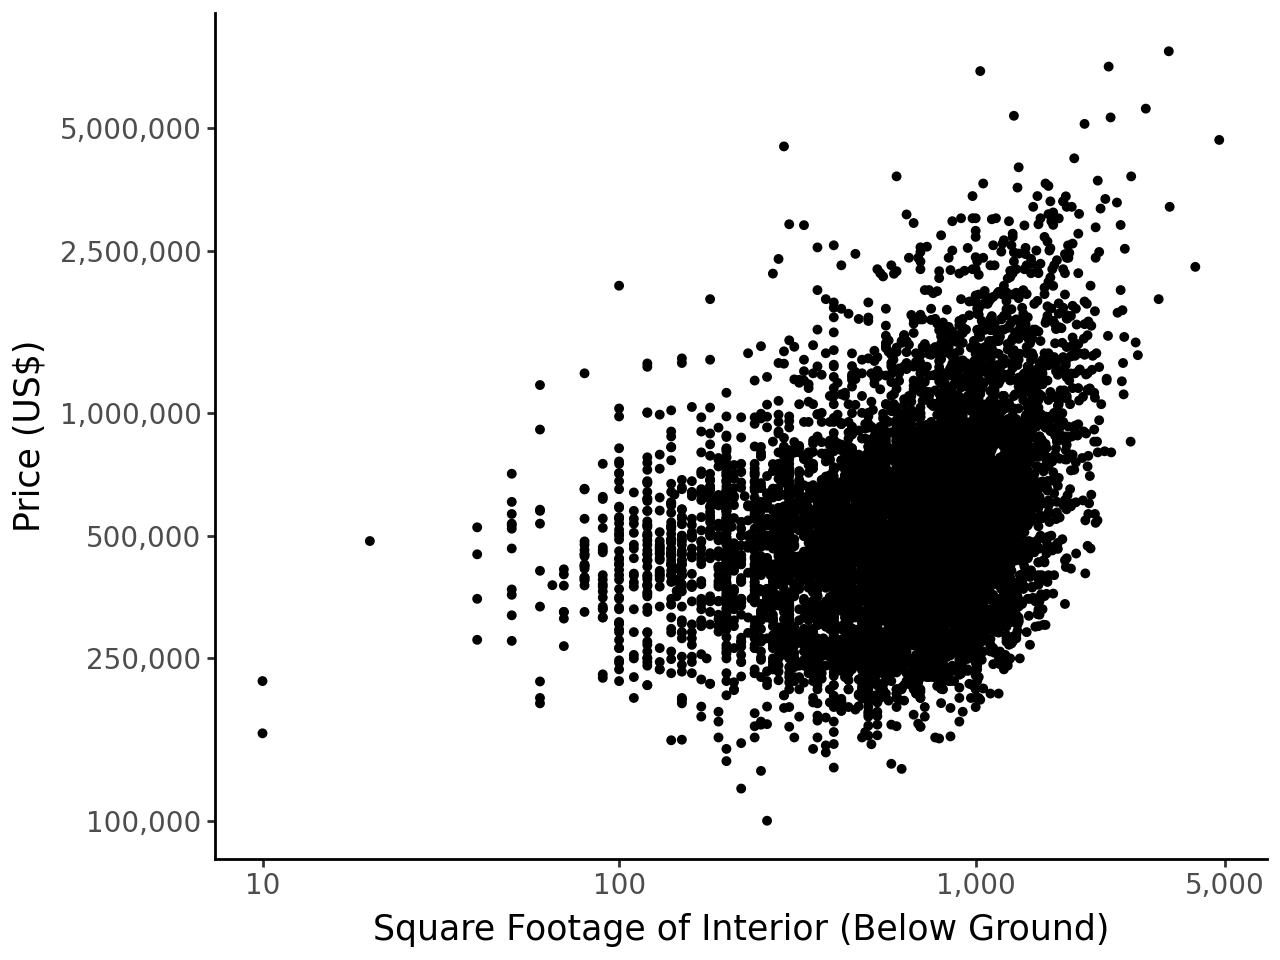

In [ ]:
# Square footage of below ground interior
# Create a subset with houses that have a below ground area
blw_data = house_data[house_data.sqft_basement > 0]

sqft_blw_plot_theme = theme(axis_title = element_text(size = 12.5),
                            axis_text = element_text(size = 10))
sqft_blw_plot = (ggplot(data = blw_data,
                        mapping = aes(x = 'sqft_basement', y = 'price')) +
  geom_point(size = 1) +
  theme_classic() +
  xlab('Square Footage of Interior (Below Ground)') +
  ylab('Price (US$)') +
  sqft_blw_plot_theme +
  scale_x_continuous(trans = 'log',
                     breaks = np.array([10, 100, 1000, 5000]),
                     labels = np.array(['10', '100', '1,000', '5,000'])) +
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
)
sqft_blw_plot

Basement square footage shows some positive relationship with price, though most properties have similar basement sizes (approximately 1,000 square feet).

### 2.6 Property Configuration

We next examine how the internal configuration of properties relates to their value:

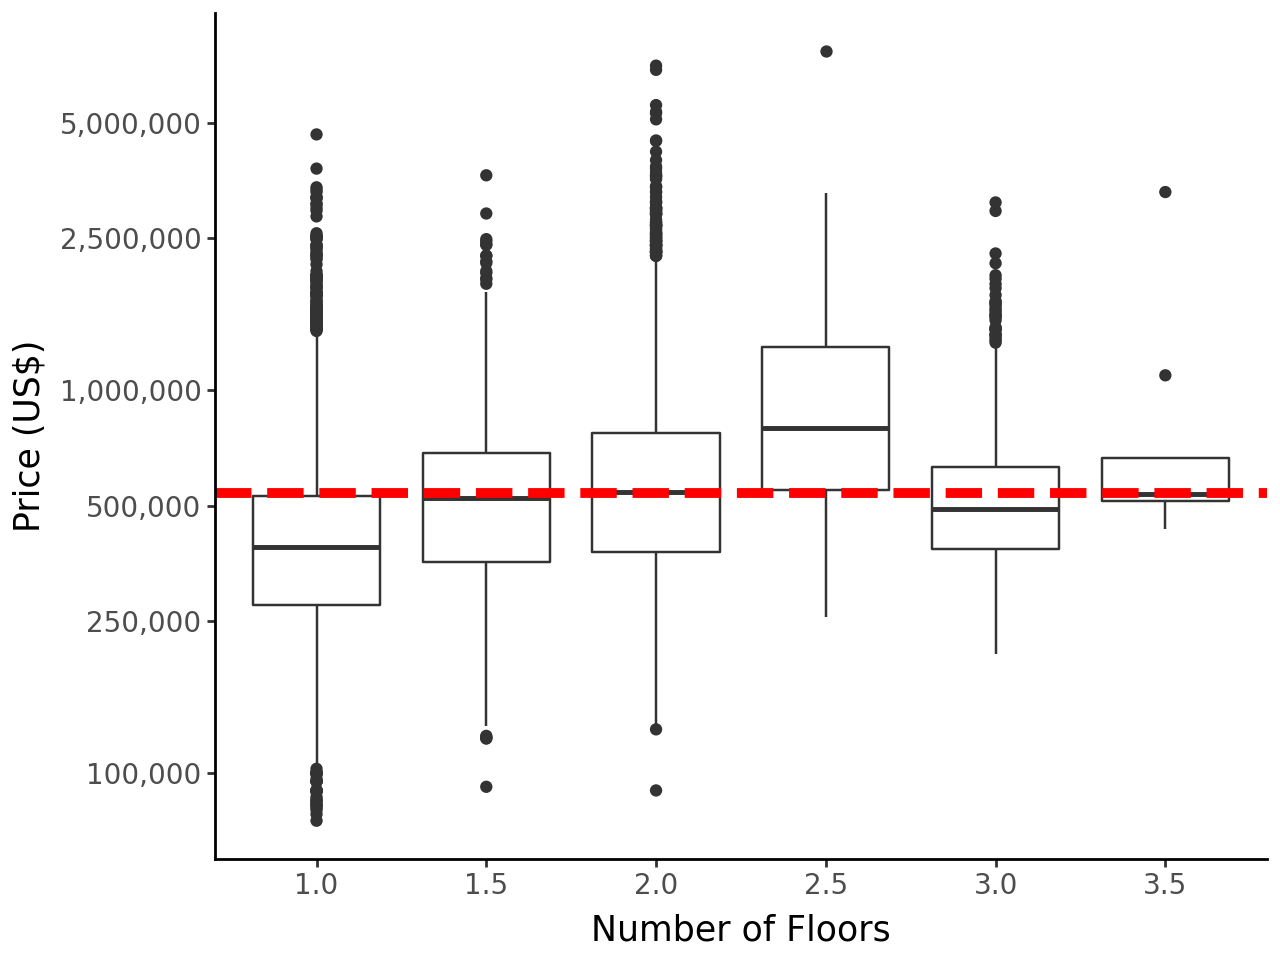

In [ ]:
# Floors
floor_plot_theme = theme(axis_title = element_text(size = 12.5),
                         axis_text = element_text(size = 10))
floor_plot = (ggplot(data = house_data,
                     mapping = aes(x = house_data['floors'].astype('category'),
                                   y = 'price')) +
  geom_boxplot() +
  geom_hline(yintercept = house_data['price'].mean(),
             linetype = 'dashed', color = 'red', size = 2) +
  theme_classic() +
  xlab('Number of Floors') +
  ylab('Price (US$)') +
  floor_plot_theme +
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
)
floor_plot

The number of floors shows a non-linear relationship with price. Two and 2.5-story homes tend to command higher prices than either single-story or 3+ story homes. This may reflect market preferences for layouts that balance convenience with space efficiency.

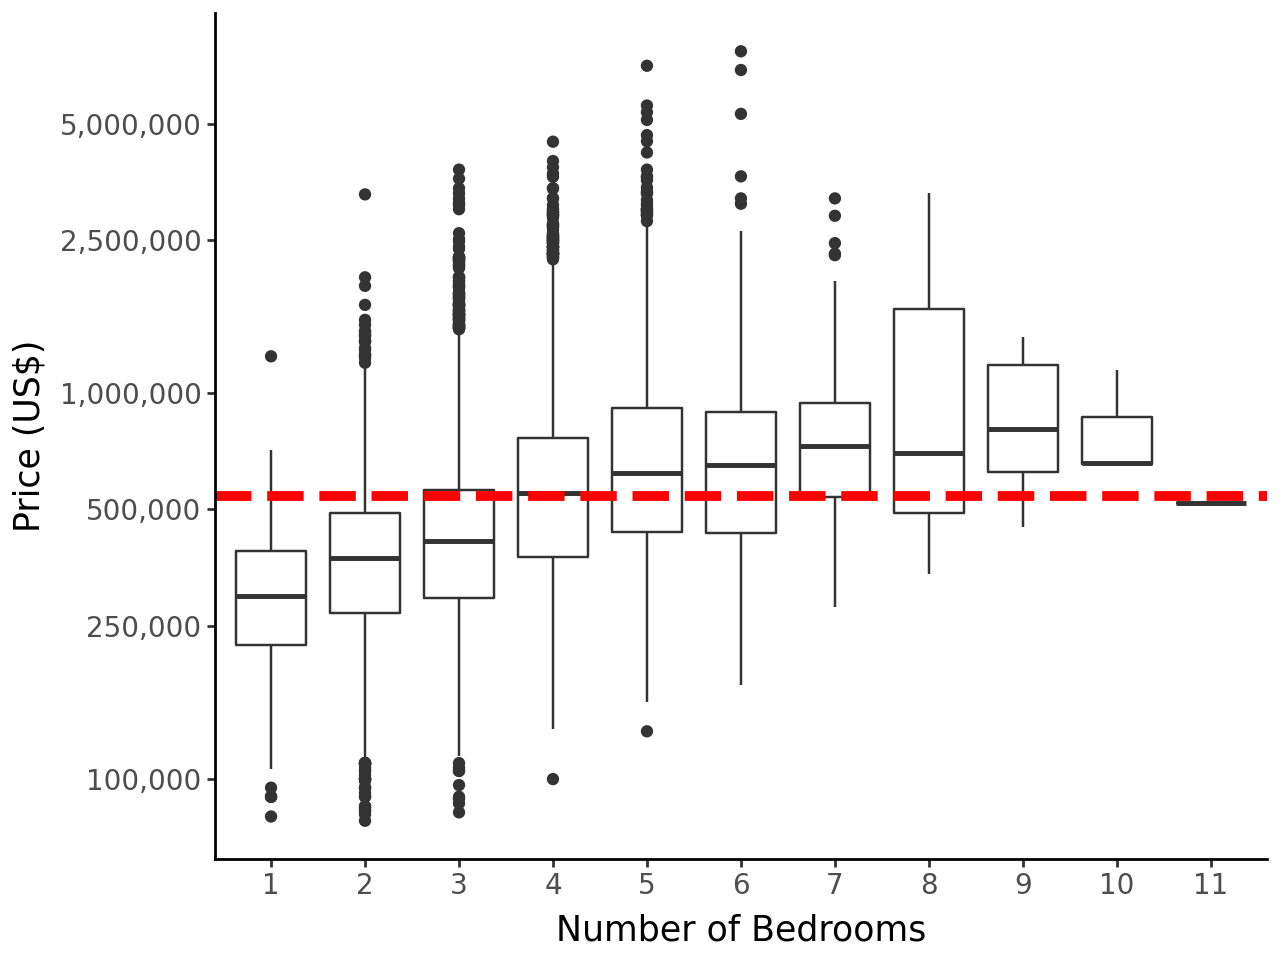

In [ ]:
# bedrooms
bed_plot_theme = theme(axis_title = element_text(size = 12.5),
                       axis_text = element_text(size = 10))
bed_plot = (ggplot(data = house_data,
                   mapping = aes(x = house_data['bedrooms'].astype('category'),
                                 y = 'price')) +
  geom_boxplot() +
  # makes a boxplot
  geom_hline(yintercept = house_data['price'].mean(),
             linetype = 'dashed', color = 'red', size = 2) +
  # add line denoting mean house price
  theme_classic() + # white background, no gridlines
  xlab('Number of Bedrooms') + # change x axis label
  ylab('Price (US$)') + # change y axis label
  bed_plot_theme + # change axis title and text size
  scale_y_continuous(trans = 'log',
                     breaks = np.array([100000, 250000, 500000, 1000000,
                                        2500000, 5000000]),
                     labels = np.array(['100,000', '250,000', '500,000',
                                        '1,000,000', '2,500,000', '5,000,000']))
  # change y-axis values
  )
bed_plot

This graph is interesting in that it highlights there are some houses with **zero** bedrooms and one house with **33** bedrooms. I believe that it doesn’t make sense for a house not to have at least one bedroom and the house with 33 is clearly an outlier, so these houses will be removed. As for the trend, there is generally an increase in median house price as the number of bedrooms increases.

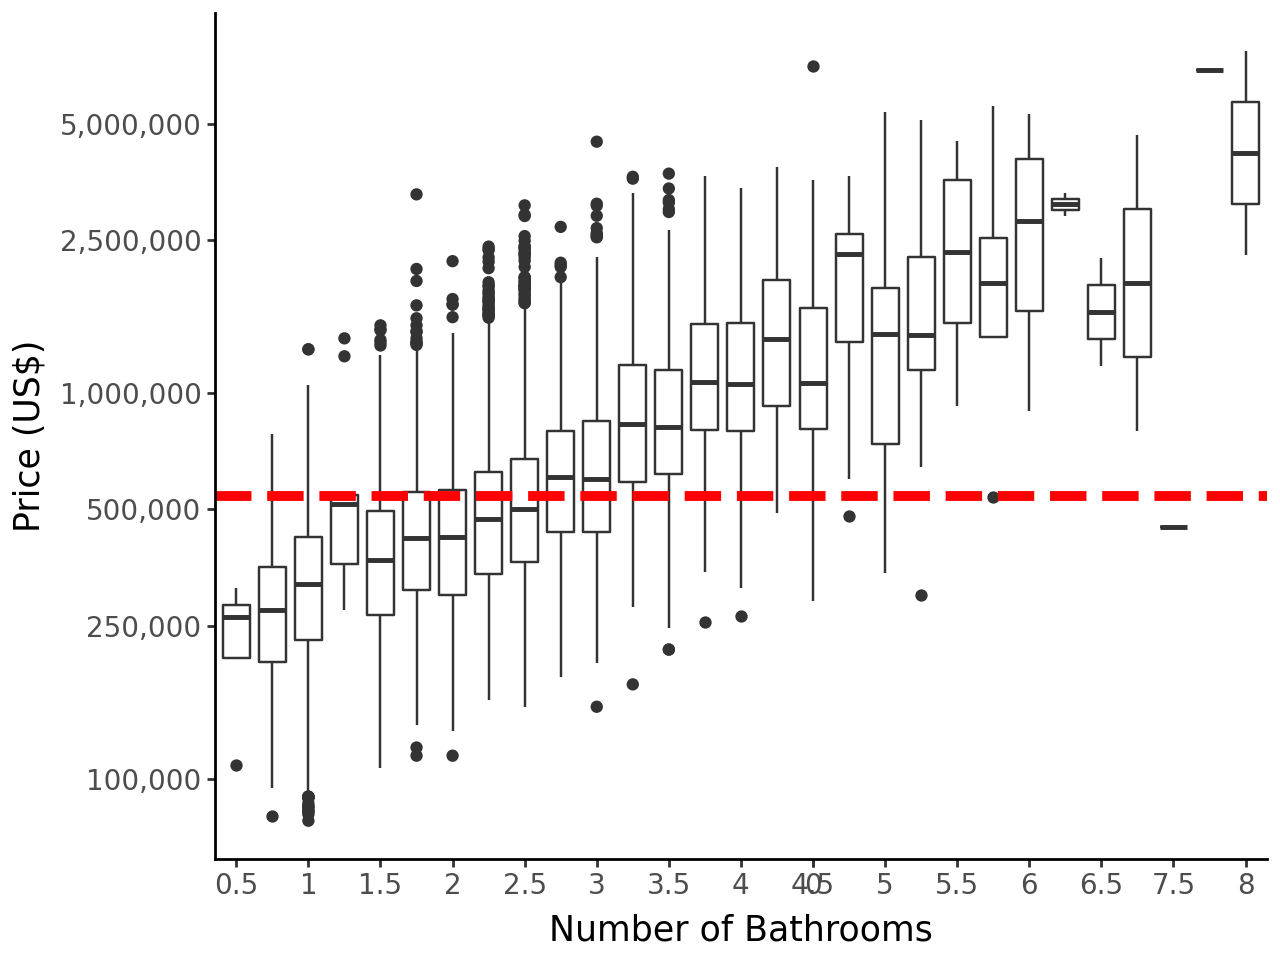

In [ ]:
from plotnine import *
import pandas as pd
import numpy as np

# bathrooms
bath_plot_theme = theme(axis_title=element_text(size=12.5),
                        axis_text=element_text(size=10))

bath_plot = (
    ggplot(data=house_data,
           mapping=aes(x=house_data['bathrooms'].astype('category'),
                       y='price')) +
    geom_boxplot() +
    geom_hline(yintercept=house_data['price'].mean(),
               linetype='dashed', color='red', size=2) +
    theme_classic() +
    xlab('Number of Bathrooms') +
    ylab('Price (US$)') +
    bath_plot_theme +
    scale_x_discrete(
        breaks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5,
                5, 5.5, 6, 6.5, 7.5, 8],
        labels=['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5',
                '5', '5.5', '6', '6.5', '7.5', '8']
    ) +
    scale_y_continuous(
        trans='log',
        breaks=[100000, 250000, 500000, 1000000, 2500000, 5000000],
        labels=['100,000', '250,000', '500,000', '1,000,000', '2,500,000', '5,000,000']
    )
)

bath_plot

The data reveals some peculiarities, including properties with zero bedrooms (likely studios) and one with 33 bedrooms (an outlier). Generally, more bedrooms and bathrooms correlate with higher prices, though this relationship likely reflects overall home size rather than just room count.

In [ ]:
# Remove outliers and invalid values
house_data = house_data[(house_data.bedrooms < 33) & (house_data.bedrooms > 0)
                        & (house_data.bathrooms > 0)]

We remove these anomalous records from the dataset to improve modeling quality.

### 2.7 Geographic Distribution

Finally, we visualize the geographic distribution of properties to understand spatial patterns in the housing market:

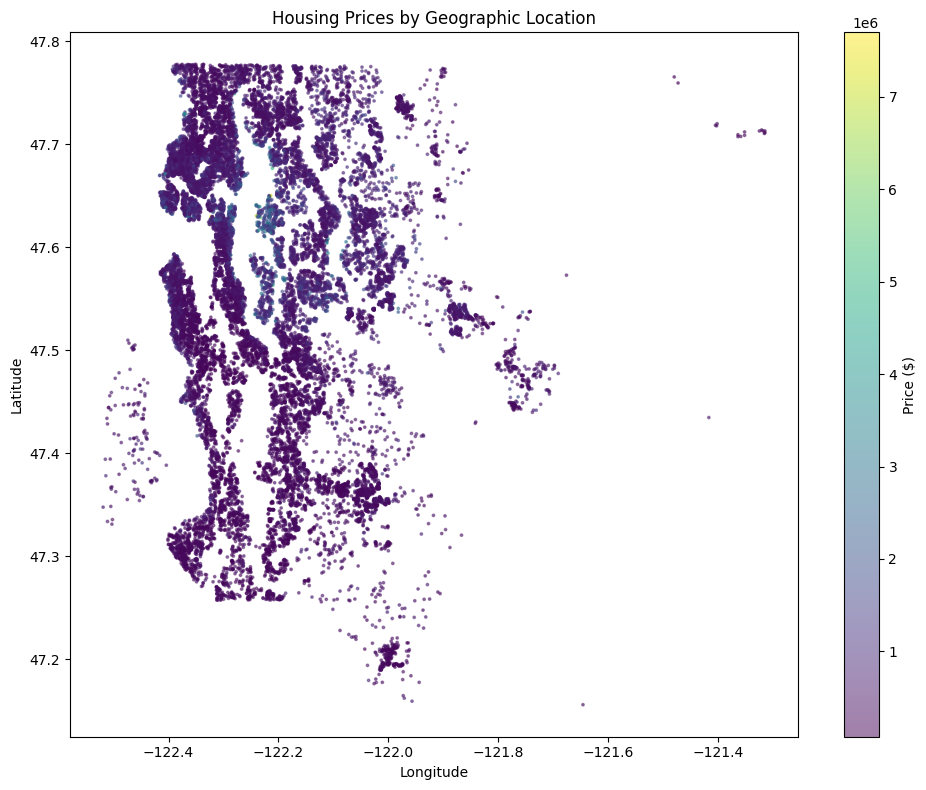

In [5]:
# Geographic distribution visualization
# Note: Full interactive map code not included due to resource constraints
# The map shows housing prices across King County with color coding:
# - Green: Houses under $500,000 (predominantly southern regions)
# - Blue: Houses $500,000-$1,000,000 (more evenly distributed)
# - Navy: Houses over $1,000,000 (concentrated in northern areas and waterfront)
#
# See static visualization in images/geographic_distribution.png
# Interactive version available in the GitHub repository

# Creating simplified static visualization instead
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(house_data['long'], house_data['lat'],
           c=house_data['price'], cmap='viridis',
           alpha=0.5, s=3)
plt.colorbar(label='Price ($)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Housing Prices by Geographic Location')
plt.tight_layout()
plt.show()

It is immediately apparent that the more expensive houses are generally located near water and cheaper houses are generally more inland, confirming the observations in **section 2.4**. For example, there are no houses worth less than $500,000 on Mercer Island. The more expensive houses are also generally more northern than the cheapest houses, if you select only the cheapeast and most expensive price groups this is clear. Therefore, we might expect that latitude will be a significant predictor of the price of a house.

## 3. Linear Model Approaches

In a linear model, a quantitative response can be predicted by one or more predictors, and you assume there is approximately a linear relationship between the response and the predictors. You typically fit a standard linear model using **least squares**.

Least squares is an approach to maximise the ‘closeness’ of the fit of the model to the data by minimising the **residual sum of squares** (RSS). The residual for an observation is the distance between the observed response and the predicted response from the model.
Consider the graph below:

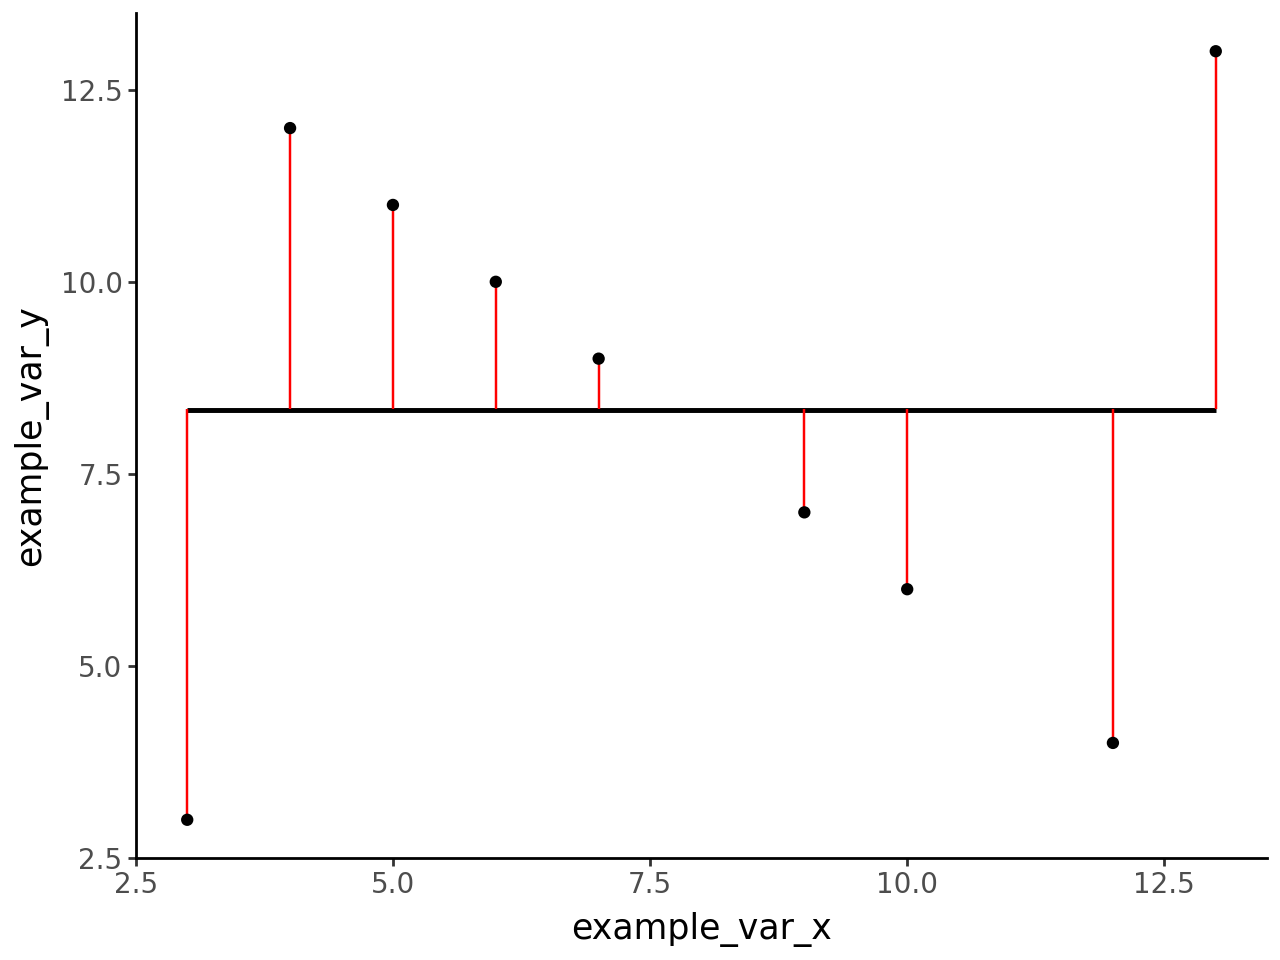

In [ ]:
# create mock data
example_var_x = [7, 6, 9, 4, 12, 5, 10, 3, 13]
example_var_y = [9, 10, 7, 12, 4, 11, 6, 3, 13]
example_data = pd.DataFrame({'Variable 1': example_var_x,
                             'Variable 2': example_var_y})

# plot data, and highlight the residuals
residual_plot = (ggplot(mapping = aes(x = 'example_var_x', y = 'example_var_y'),
                        data = example_data) +
  geom_smooth(method = 'lm', se = False, colour = 'black') +
  geom_segment(aes(xend = 'Variable 1', yend = 8.35),
               colour = 'red') +
  geom_point() +
  theme_classic() +
  theme(axis_title = element_text(size = 12.5),
        axis_text = element_text(size = 10))
  )
residual_plot

Here you can see the least squares estimate for the relationship between the data. The residuals are highlighted in red. The RSS is minimised such that any different intercept or slope would result in a higher RSS - i.e. the line you see cannot be changed or it will not fit the data as well. The residuals are added together, and that value is squared. This removes any negative sign, as we are only concerned with the total distance, not its direction.

However, there are other approaches to improve the performance of the model other than least squares. These approaches seek to improve prediction accuracy and model interpretability.

For my predictive modelling, the variables ‘id’, ‘date’ and ‘zipcode’ will be removed. Furthermore, the variables ‘price’ ,‘sqft_living’, ‘sqft_lot’, ‘sqft_above’, ‘sqft_basement’, ‘sqft_living15’ and ‘sqft_lot15’ will be log-transformed.

### 3.1 Data Preprocessing

Before building predictive models, we perform necessary preprocessing:

In [3]:
# Remove unnecessary variables
model_data = house_data.drop(columns = ['id', 'date', 'zipcode'])

# Log transform variables with skewed distributions
model_data['price'] = np.log(model_data['price'])
model_data['sqft_living'] = np.log(model_data['sqft_living'])
model_data['sqft_lot'] = np.log(model_data['sqft_lot'])
model_data['sqft_above'] = np.log(model_data['sqft_above'])
model_data['sqft_basement'] = np.log(model_data['sqft_basement'] + 1)  # Adding 1 to handle zeros
model_data['sqft_living15'] = np.log(model_data['sqft_living15'])
model_data['sqft_lot15'] = np.log(model_data['sqft_lot15'])

# Create matrix to track model performance
model_stats = pd.DataFrame(columns = ['Test MSE'],
                           index = [
                               'Best subset selection',
                               'Forward stepwise selection',
                               'Backward stepwise selection',
                               'Ridge regression',
                               'Lasso regression', 'PCR', 'PLS',
                               'Single regression tree', 'Bagging',
                               'Random forest', 'Boosting'
                               ]
                           )

# Split data into training (75%) and test (25%) sets
x = model_data.drop('price', axis = 1)
y = pd.DataFrame(model_data.price)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25,
                                                    random_state = 35)

Key preprocessing steps include:
- Removing non-predictive variables (ID, date, zipcode)
- Log-transforming price and size variables to normalize their distributions
- Creating a framework to track model performance
- Splitting the data into training (75%) and test (25%) sets

### 3.2 Subset Selection Methods

#### 3.2.1 Best Subset Selection

Best subset selection evaluates all possible combinations of predictors to find the optimal model:

In [ ]:
# Best subset selection results (computation intensive)
lm_test_MSE = 0.06351712398582668
best_feature_names_ = ('bedrooms', 'bathrooms', 'sqft_living',
                       'sqft_lot', 'floors', 'waterfront', 'view',
                       'condition', 'grade', 'sqft_above', 'sqft_basement',
                       'yr_built', 'yr_renovated', 'lat', 'sqft_living15', 'sqft_lot15')

print('Test set MSE: %.5f' % lm_test_MSE)
print('Number of features chosen:', len(best_feature_names_))
print('Features chosen:', best_feature_names_)

Test set MSE: 0.06352
Number of features chosen: 16
Features chosen: ('bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'sqft_living15', 'sqft_lot15')


Best subset selection identifies a 16-variable model as optimal, excluding only the 'long' (longitude) variable. Cross-validation via 10-fold splitting was used to determine the optimal subset.

The model selection process evaluates the cross-validation error for models of different sizes:

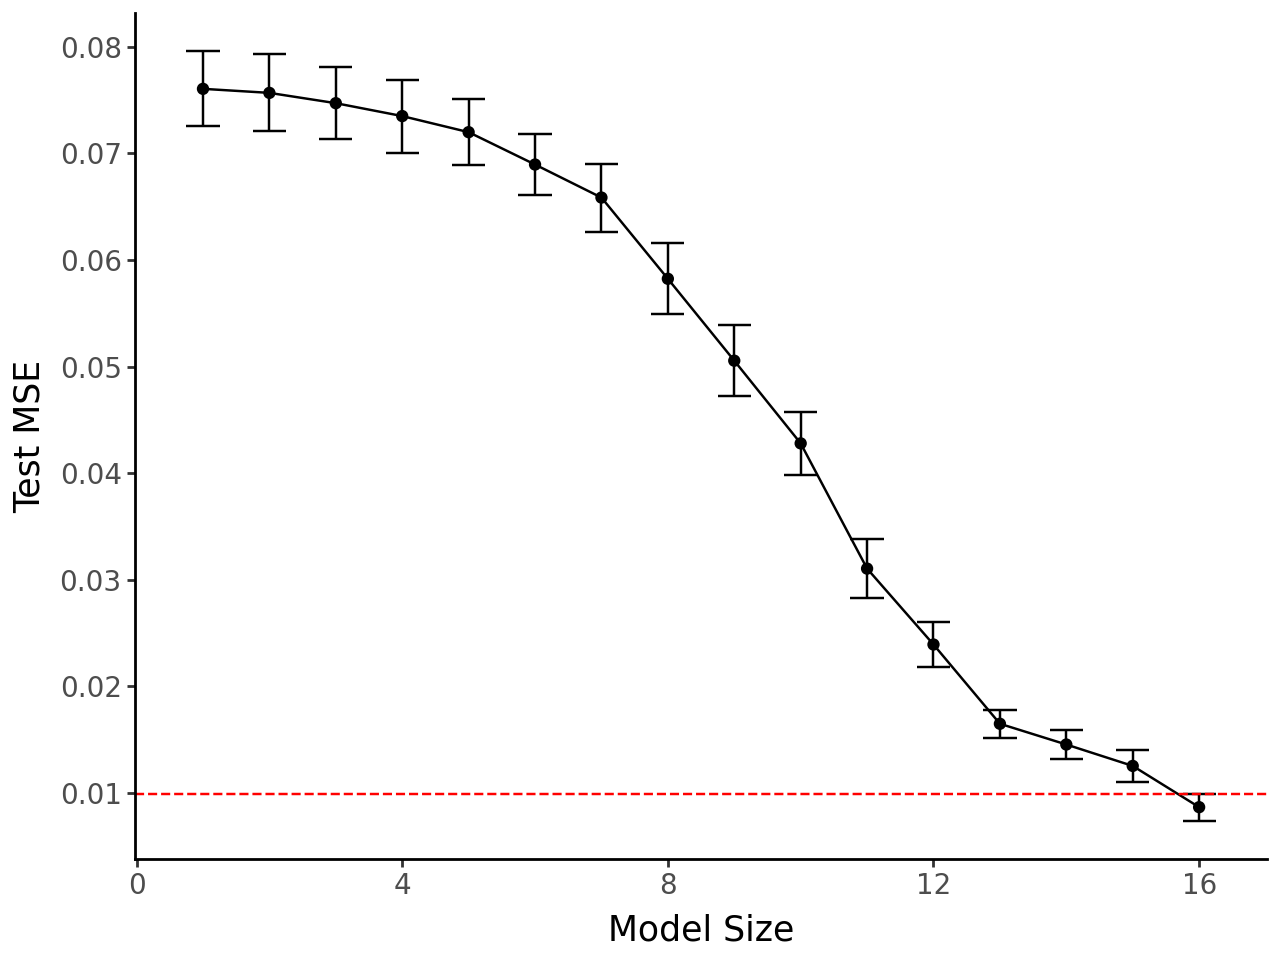

In [ ]:
# because EFS doesn't work, I've recreate the table produced below

# extract stats of efs
#efs_stats = pd.DataFrame.from_dict(efs.get_metric_dict()).T

# dataframe to add the test mse and standard errors for the best model at
# each size
#efs_best_models = pd.DataFrame(columns = ['CV_score', 'std_error'])

# for each sized model
#for i in range(1, 17, 1):

    #indexes = [] # list to track the indexes in efs_stats of the models with
    # size i

    # iterate over all the models in efs_stats
    #for j in range(0, len(efs_stats)):

        # if the length of the model is equal to i
        #if len(efs_stats['feature_names'][j]) == i:

            # add the index (j) to indexes
            #indexes.append(j)

    # extract the index of the model with the lowest cross val score
    #min_avg_score_index = efs_stats[min(indexes):max(indexes)]['avg_score'].astype(float).idxmin(axis = 1)

    # use that index to extract the cv_score and std_error
    #efs_best_models.at[i, 'CV_score'] = np.square(efs_stats['avg_score'][min_avg_score_index])
    #efs_best_models.at[i, 'std_error'] = efs_stats['std_err'][min_avg_score_index]

# change columns to floats
#efs_best_models = efs_best_models.astype(float)


# recreated table
efs_best_models = efs_best_models1 = pd.DataFrame(data = {'CV_score': [0.07605759865727282,
                                                                       0.07567839005496807,
                                                                       0.07471145477652824,
                                                                       0.0735012308766475,
                                                                       0.07199211537679669,
                                                                       0.06895525155189056,
                                                                       0.06585606580426408,
                                                                       0.05823823994049927,
                                                                       0.050553675178276816,
                                                                       0.042796856332271004,
                                                                       0.0310474069290086,
                                                                       0.023926368298656284,
                                                                       0.016491804302500277,
                                                                       0.014544475614421114,
                                                                       0.012536455653603465,
                                                                       0.00866700519371302],
                                                          'std_error': [0.0035234919449906965,
                                                                        0.003613041317735649,
                                                                        0.0033761903770162245,
                                                                        0.0034232814493334184,
                                                                        0.003101720687690171,
                                                                        0.002839548464126151,
                                                                        0.003184049048283974,
                                                                        0.0033458532098801174,
                                                                        0.0033063287428112265,
                                                                        0.0029888377848824275,
                                                                        0.002766817317231102,
                                                                        0.002141453537275933,
                                                                        0.0013362830904681947,
                                                                        0.0013186797000082193,
                                                                        0.0014868116451182763,
                                                                        0.0012730036196126162,]},
                                                  index = list(range(1, 17)))


# plot scores with std errors
plot_bss_cv_theme = theme(axis_title = element_text(size = 12.5),
                          axis_text = element_text(size = 10))
plot_bss_cv = (ggplot(data = efs_best_models,
                      mapping = aes(x = np.array(range(1, 17, 1)),
                                    y = 'CV_score')) +
  geom_point() + # plot points
  geom_line() + # join points with line
  geom_errorbar(mapping = aes(ymin = efs_best_models['CV_score'] -
                              efs_best_models['std_error'],
                              ymax = efs_best_models['CV_score'] +
                              efs_best_models['std_error'])) +

  # add standard error bars
  geom_hline(yintercept = 0.00994000519371302, linetype = 'dashed',
             colour = 'red') + # add line denoting the standard error
  # above the best model
  theme_classic() + # white background, no gridlines
  xlab('Model Size') + # change x axis label
  ylab('Test MSE') + # change y axis label
  plot_bss_cv_theme + # change the size of axis titles and axis text
  scale_y_continuous(breaks = np.array(np.arange(0, 0.09, 0.01)),
                     labels = np.array(np.arange(0, 0.09, 0.01)))
  # change y-axis limits
  )
plot_bss_cv

The 16-variable model has the lowest test MSE (0.0635), and no smaller model falls within one standard error of this performance, confirming it as the optimal selection.

In [ ]:
# add test set MSE to matrix
model_stats.loc['Best subset selection', 'Test MSE'] = lm_test_MSE

#### 3.2.2 Forward Stepwise Selection

Forward stepwise selection builds models incrementally, starting with zero variables and adding the most beneficial predictor at each step:

<ipython-input-28-fa8b5243e03d>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3594: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
<ipython-input-28-fa8b5243e03d>:118: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


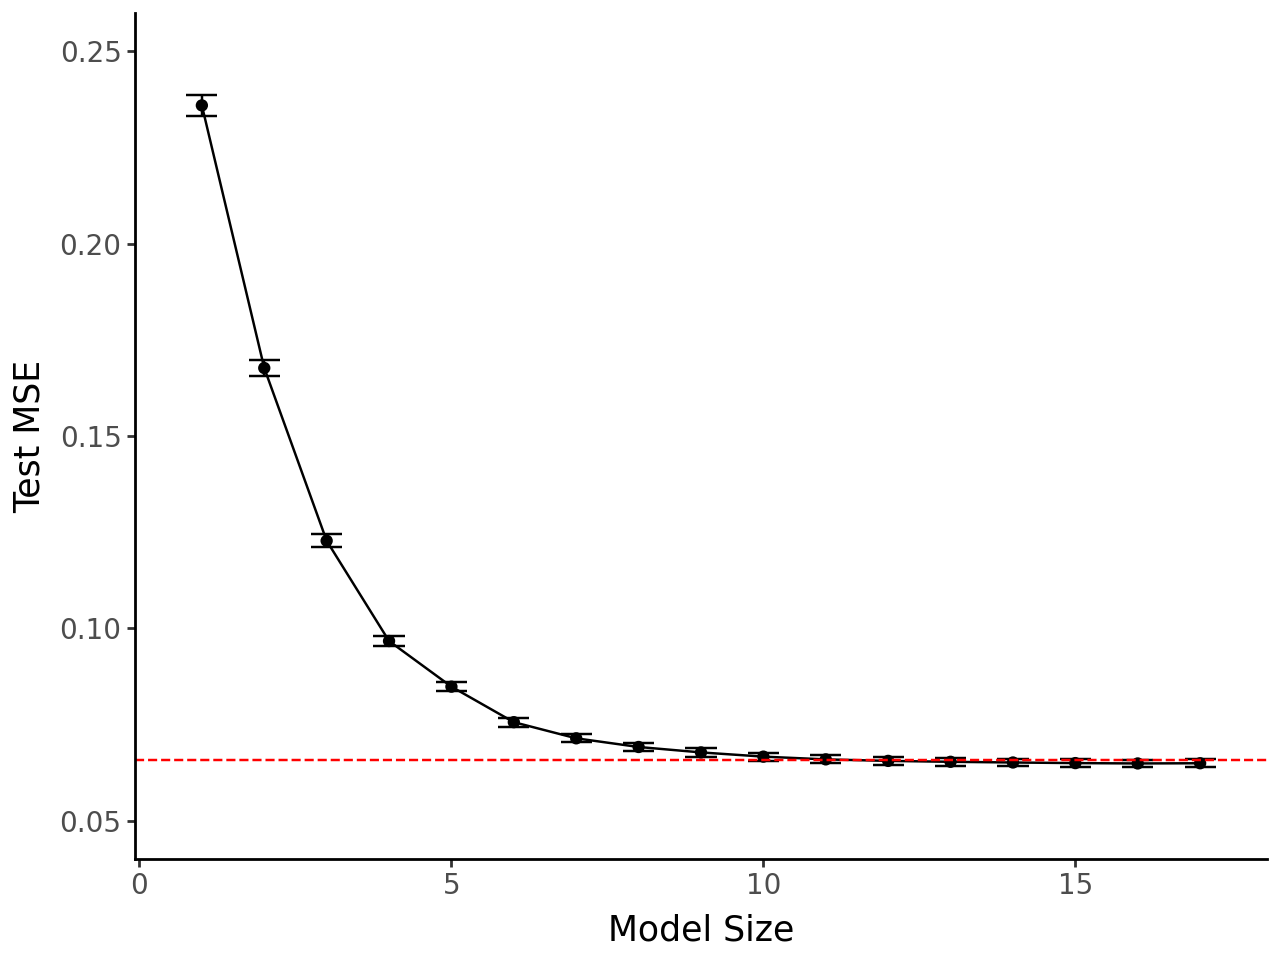

In [ ]:
## Forward stepwise selection
# taken and adapted from:
# http://www.science.smith.edu/~jcrouser/SDS293/labs/lab9-py.html

# using 10-fold cross-validation, so set that up first
k = 10
np.random.seed(seed = 35) # set seed to ensure reproducibility
folds = np.random.choice(k, size = len(y), replace = True)

# dataframe to track cross-validation errors
crossVal_errors_fwd = pd.DataFrame(
    columns = range(1, k + 1),
    index = range(1, 18))

# function to fit a linear model
def processSubset(features, X_train, Y_train, X_test, Y_test):
    # fit to training set
    model = sm.OLS(Y_train, X_train[list(features)])
    model_fit = model.fit()

    # calculate test set MSE by using the fitted model to make predictions on
    # the test set
    predictions = model_fit.predict(X_test[list(features)])
    test_MSE = np.mean((Y_test.subtract(predictions, axis = 0))**2)
    test_MSE = test_MSE.tolist()

    return {'Model': model_fit, 'Test MSE': test_MSE}

# function to perform forward stepwise selection
def forward_stepwise_selection(predictors, X_train, Y_train, X_test, Y_test):
    results = [] # empty for now

    # extract predictors that still need to be checked
    # checks if each predictor in x_train is also not in predictors
    remaining_predictors = [p for p in X_train.columns if p not in predictors]

    # for each of the remaining predictors
    for p in remaining_predictors:

        # call processSubset to fit a linear model using predictors + each
        # of the remaining predicotrs
        results.append(processSubset(predictors + [p],
                                     X_train, Y_train, X_test, Y_test))

    # turn results into a dataframe
    models = pd.DataFrame(results)

    # choose the best model (with the lowest test set MSE)
    models.sort_values('Test MSE', inplace = True, axis = 0)
    best_model = models[:1]

    return best_model

# now write a for loop performing cross-validation
# in the ith fold, the elements of folds that equal i are in the test set and
# the remainder are in the training
# dataframe to track the cross_validation errors for each model size
models_crossVal_errors_fwd = pd.DataFrame(columns = ['Model', 'Test MSE'])

# iterate over each fold
for i in range(1, k + 1):

    # reset predictors
    predictors = []

    # iterate over each model size
    for j in range(1, len(x.columns) + 1):

        # create train sets using all but fold i and test sets using the
        # remaining fold i
        x_train = x[folds != (i - 1)]
        y_train = y[folds != (i - 1)]
        x_test = x[folds == (i - 1)]
        y_test = y[folds == (i - 1)]

        # call forward_stepwise_selection, training on every fold except i
        # test on the ith fold
        fss = forward_stepwise_selection(
            predictors, x_train, y_train, x_test, y_test)

        # add model and test MSE for this fold i to models_crossVal_errors
        models_crossVal_errors_fwd = pd.concat([models_crossVal_errors_fwd, fss], ignore_index=True)


        # in order to add the test MSE for this model, the index of fss needs
        # to be called but this changes over time, so the following code
        # extracts the relevant index
        # convert column to series
        fss_test_MSE_column = pd.Series(fss['Test MSE'])
        # extract index value as a list
        fss_test_MSE_index = fss.index.values.tolist()
        # convert element in fss_index to str
        index_str = [str(i) for i in fss_test_MSE_index]
        fss_index = str(''.join(index_str))

        # add test MSE for this model size (j) and fold (i) to
        # crossVal_errors_fwd - fss_index is finally converted to int
        crossVal_errors_fwd.at[j, i] = pd.Series(fss['Test MSE'][int(fss_index)])

        # extract predictors
        predictors = list(fss['Model'])[0].model.exog_names
        # this ensures that when the j loop runs again, the predictors start
        # with the best selection at the previous model size

# this results in a matrix of test MSE, where the (i,j)th element is
# equal to the test MSE for the ith cross-validation fold for the best
# j-variable model
# obtain a vector for which the jth element is the cross-validation
# error for the j-variable model by averaging all the errors for that size
crossVal_errors_fwd_mean = crossVal_errors_fwd.apply(np.mean, axis = 1)

# standard error of each model size test MSE (standard deviation of test set
# MSE divided by the square root of the number of folds) before mean is found
crossVal_errors_fwd_se = pd.DataFrame(crossVal_errors_fwd_mean,
                                      columns = ['Test MSE'])

# Asegurar que los valores sean numéricos para evitar errores en .sem()
crossVal_errors_fwd = crossVal_errors_fwd.astype(float)

# Calcular error estándar para cada modelo size
crossVal_errors_fwd_se['SE'] = crossVal_errors_fwd.sem(axis=1)

crossVal_errors_fwd_se['SE'] = crossVal_errors_fwd.sem(axis = 1)

# plot
plot_fwd_cv_theme = theme(axis_title = element_text(size = 12.5),
                          axis_text = element_text(size = 10))
plot_fwd_cv = (ggplot(data = crossVal_errors_fwd_se,
                      mapping = aes(x = np.array(range(1, 18, 1)),
                                    y = 'Test MSE')) +
  geom_point() + # plot points
  geom_line() + # join points with line
  geom_errorbar(mapping = aes(ymin = crossVal_errors_fwd_se['Test MSE'] -
                              crossVal_errors_fwd_se['SE'],
                              ymax = crossVal_errors_fwd_se['Test MSE'] +
                              crossVal_errors_fwd_se['SE'])) +

  # add standard error bars
  geom_hline(yintercept = 0.0659094255830648, linetype = 'dashed',
             colour = 'red') + # add line denoting the standard error
  # above the best model
  theme_classic() + # white background, no gridlines
  xlab('Model Size') + # change x axis label
  ylab('Test MSE') + # change y axis label
  plot_fwd_cv_theme + # change the size of axis titles and axis text
  scale_y_continuous(limits = np.array([0.05, 0.25]))
  # change y-axis limits
  )
plot_fwd_cv
# the 12 variable model is the simplest model that has a test MSE within one
# standard error of the best model (16 variables)

While the 16-variable model has the lowest test MSE, a more parsimonious 12-variable model falls within one standard error of this performance. In accordance with the principle of selecting the simplest model within one standard error of the best performer, we select the 12-variable model (Test MSE: 0.066).

In [ ]:
# therefore add the test set MSE of the 12 variable model to the matrix
model_stats.loc['Forward stepwise selection',
                'Test MSE'] = crossVal_errors_fwd_se['Test MSE'][12]

#### 3.2.3 Backward Stepwise Selection

Backward stepwise selection begins with all predictors and progressively removes the least beneficial variables:

In [ ]:
## Backwards stepwise selection
# taken and adapted from:
# http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html

# using 10-fold cross-validation, so set that up first
k = 10
np.random.seed(seed = 35)
folds = np.random.choice(k, size = len(y), replace = True)

# dataframe to track cross-validation errors
crossVal_errors_bwd = pd.DataFrame(
    columns = range(1, k + 1),
    index = range(1, 18)
    )

# function to perform backward stepwise selection
def backward_stepwise_selection(predictors, X_train, Y_train, X_test, Y_test):
    results = [] # empty for now

    # for each combination of predictors (up to 16)
    for combo in itertools.combinations(predictors, len(predictors) - 1):
            # call processSubset on each combination and append to results
            results.append(processSubset(combo, X_train, Y_train, X_test, Y_test))

    # turn results into a dataframe
    models = pd.DataFrame(results)

    # choose the best model (with the lowest test set MSE)
    models.sort_values('Test MSE', inplace = True, axis = 0)
    best_model = models[:1]

    return best_model

models_crossVal_errors_bwd = pd.DataFrame(columns = ['Model', 'Test MSE'])

# iterate over each fold
for i in range(1, k + 1):

    predictors = x_train.columns

    # iterate over each model size
    while(len(predictors) > 1):

        # create train sets using all but fold i and test sets using the
        # remaining fold i
        x_train = x[folds != (i - 1)]
        y_train = y[folds != (i - 1)]
        x_test = x[folds == (i - 1)]
        y_test = y[folds == (i - 1)]

        # call backward_stepwise_selection, training on every fold except i
        # test on the ith fold
        bss = backward_stepwise_selection(
            predictors, x_train, y_train, x_test, y_test)

        # add model and test MSE for this fold i to models_crossVal_errors
        models_crossVal_errors_bwd = pd.concat([models_crossVal_errors_bwd, bss], ignore_index=True)

        # in order to add the test MSE for this model, the index of bss needs
        # to be called but this changes over time, so the following code
        # extracts the relevant index
        # convert column to series
        bss_test_MSE_column = pd.Series(bss['Test MSE'])
        # extract index value as a list
        bss_test_MSE_index = bss.index.values.tolist()
        # convert element in fss_index to str
        index_str = [str(i) for i in bss_test_MSE_index]
        bss_index = str(''.join(index_str))

        # add test MSE for this model size (j) and fold (i) to
        # crossVal_errors_bwd - bss_index is finally converted to int
        crossVal_errors_bwd.at[(len(predictors) - 1), i] = pd.Series(
            bss['Test MSE'][int(bss_index)])

        # extract predictors
        predictors = list(bss['Model'])[0].model.exog_names

# note that this means a 17 variable model is never looked at, but the point
# of this is that it should be a subset of predictors anyway, so I'm content
# with leaving the 17 variable model empty (best subset selection identified
# that the 17 variable was not the best anyway)

# this results in a matrix of test MSE, where the (i,j)th element is
# equal to the test MSE for the ith cross-validation fold for the best
# j-variable model
# obtain a vector for which the jth element is the cross-validation
# error for the j-variable model by averaging all the errors for that size
crossVal_errors_bwd_mean = crossVal_errors_bwd.apply(np.mean, axis = 1)

# standard error of each model size test MSE (standard deviation of test set
# MSE divided by the square root of the number of folds) before mean is found
crossVal_errors_bwd_se = pd.DataFrame(crossVal_errors_bwd_mean,
                                      columns = ['Test MSE'])
# Asegurarse de que los datos sean numéricos antes de operar
crossVal_errors_bwd = crossVal_errors_bwd.astype(float)

# Calcular la media del Test MSE por tamaño del modelo
crossVal_errors_bwd_mean = crossVal_errors_bwd.mean(axis=1)

# Calcular el error estándar por tamaño del modelo (std / sqrt(n))
crossVal_errors_bwd_se = pd.DataFrame({
    'Test MSE': crossVal_errors_bwd_mean,
    'SE': crossVal_errors_bwd.sem(axis=1)
})


plot_bwd_cv_theme = theme(axis_title = element_text(size = 22.5),
                          axis_text = element_text(size = 20))
plot_bwd_cv = (ggplot(data = crossVal_errors_bwd_se,
                      mapping = aes(x = np.array(range(1, 18, 1)),
                                    y = 'Test MSE')) +
  geom_point() + # plot points
  geom_line() + # join points with line
  geom_errorbar(mapping = aes(ymin = crossVal_errors_bwd_se['Test MSE'] -
                              crossVal_errors_bwd_se['SE'],
                              ymax = crossVal_errors_bwd_se['Test MSE'] +
                              crossVal_errors_bwd_se['SE'])) +

  # add standard error bars
  geom_hline(yintercept = 0.06589432278232081, linetype = 'dashed',
             colour = 'red') + # add line denoting the standard error
  # above the best model
  theme_classic() + # white background, no gridlines
  xlab('Model Size') + # change x axis label
  ylab('Test MSE') + # change y axis label
  plot_bwd_cv_theme + # change the size of axis titles and axis text
  scale_y_continuous(limits = np.array([0.05, 0.3]))
  # change y-axis limits
  )
plot_bwd_cv
# the 12 variable model is the simplest model that has a test MSE within one
# standard error of the best model (16 variables)

# therefore add the test set MSE of the 12 variable model to the matrix
model_stats.loc['Backward stepwise selection',
                'Test MSE'] = crossVal_errors_fwd_se['Test MSE'][12]

<ipython-input-30-8035e5e7d0be>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3594: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
<ipython-input-30-8035e5e7d0be>:95: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


Similar to forward selection, backward selection identifies a 12-variable model as the most parsimonious option within one standard error of the best performer (Test MSE: 0.066).

### 3.3 Shrinkage Methods

#### 3.3.1 Ridge Regression


The previous three approaches were methods for selecting subsets of predictors. Ridge regression is an approach that uses all predictors, but it shrinks the coefficent estimates (intercept and slope) towards zero which reduces their variance. Ridge regression does seek to minimise RSS (like least squares) but it introduces another term called a **shrinkage penalty**. The tuning paramter (*lambda*, λ) controls the impact of both terms.

When λ = 0, the shrinkage penalty is not in effect, so ridge regression is just performing least squares. As λ increases, the shrinkage penalty grows and the coefficients approach zero. When λ is extremely large, the coefficients will be essentially zero (but never exactly) - leading to a null model with no predictors. How do you select a good value of λ?
Cross-validation!

You can create a grid of λ values, then use 10-fold cross-validation to train a ridge regression model for every value of λ in the grid. The ‘best’ model with the ‘best’ λ value is the model that has the lowest test MSE. Let’s see how ridge regression performs:

In [ ]:
# set grid of alpha values
grid = 10**np.linspace(10, -2, 100)*0.5

# perform ridge regression with 10-fold cross-validation to find the best alpha,
# scoring is mean squared error (MSE)
ridge_model = RidgeCV(alphas = grid, scoring = 'neg_mean_squared_error', cv = 10)
# fit to training data
ridge_model.fit(x_train, y_train)
# extract best alpha
ridge_best_alpha = ridge_model.alpha_

# new ridge model with best alpha
ridge2 = Ridge(alpha = ridge_best_alpha)
# fit to training data
ridge2.fit(x_train, y_train)
# predict on test data
mean_squared_error(y_test, ridge2.predict(x_test))

0.0619733794221566

Ridge regression achieves a test MSE of 0.0620, outperforming all subset selection methods. The regularization helps control overfitting while still utilizing all predictors.

In [ ]:
# add test MSE to matrix
model_stats.loc['Ridge regression',
                'Test MSE'] = mean_squared_error(y_test, ridge2.predict(x_test))

# show models so far
model_stats

,Test MSE
Best subset selection,0.063517
Forward stepwise selection,0.065554
Backward stepwise selection,0.065554
Ridge regression,0.061973
Lasso regression,NaN
PCR,NaN
PLS,NaN
Single regression tree,NaN
Bagging,NaN
Random forest,NaN


So we can see that the ridge regression with the best λ is the best model so far (with the lowest test MSE). Best subset selection is the best of the subset selection methods with forward and backward stepwise selection arriving at the same test MSE, slightly worse than best subset selection.

#### 3.3.2 Lasso Regression


This approach is also a shrinkage method, like ridge regression. In ridge regression, the fact that the coefficients are shrunk towards zero improves accuracy, but it can be difficult to interpret. Lasso regression overcomes this by shrinking coefficients towards zero and forces some to be exactly zero - it performs variable selection like the subset methods by removing variables.

Just like ridge regression, lasso regression uses λ. The same grid of λ values will be used, then 10-fold cross-validation will be used to train a lasso regression model for every value of λ in the grid. The ‘best’ model with the ‘best’ λ value is the model that has the lowest test MSE. Let’s see how lasso regression performs:

In [ ]:
# Lasso regression with cross-validation
lasso_model = LassoCV(alphas = grid, cv = 10, random_state = 35)
lasso_model.fit(x_train, y_train.values.ravel())
lasso_best_alpha = lasso_model.alpha_

# Model with optimal alpha
lasso2 = Lasso(alpha = lasso_best_alpha)
lasso2.fit(x_train, y_train)
lasso_test_mse = mean_squared_error(y_test, lasso2.predict(x_test))
print(f"Lasso regression test MSE: {lasso_test_mse:.5f}")

Lasso regression test MSE: 0.06526


Lasso regression yields a test MSE of 0.0652, which is better than forward and backward stepwise selection but not as good as ridge regression or best subset selection.

### 3.4 Dimension Reduction Methods

#### 3.4.1 Principal Components Regression (PCR)

PCR transforms the predictor space into principal components before regression:

Principal components regression (PCR) is a dimension reduction technique.
There is one dimension for each predictor.
The first principal component is the direction through the data that captures the most variation in the data - a linear combination of all features.
The hope is that only a few components are responsible for most of the variation in the data and if all principal components are included in a model, this is just least squares.
It is similar to ridge regression, in that all the predictors are included - i.e. it does not perform variable selection.

I'll refer you to some other sources for a better and more in-depth explanation: [Hands on Machine Learning with R, Chapter 17](https://bradleyboehmke.github.io/HOML/pca.html)
and [An Introduction to Statistical Learning (page 231)](https://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf).

You decide on the number of components by performing cross-validation.
PCR performs as follows:

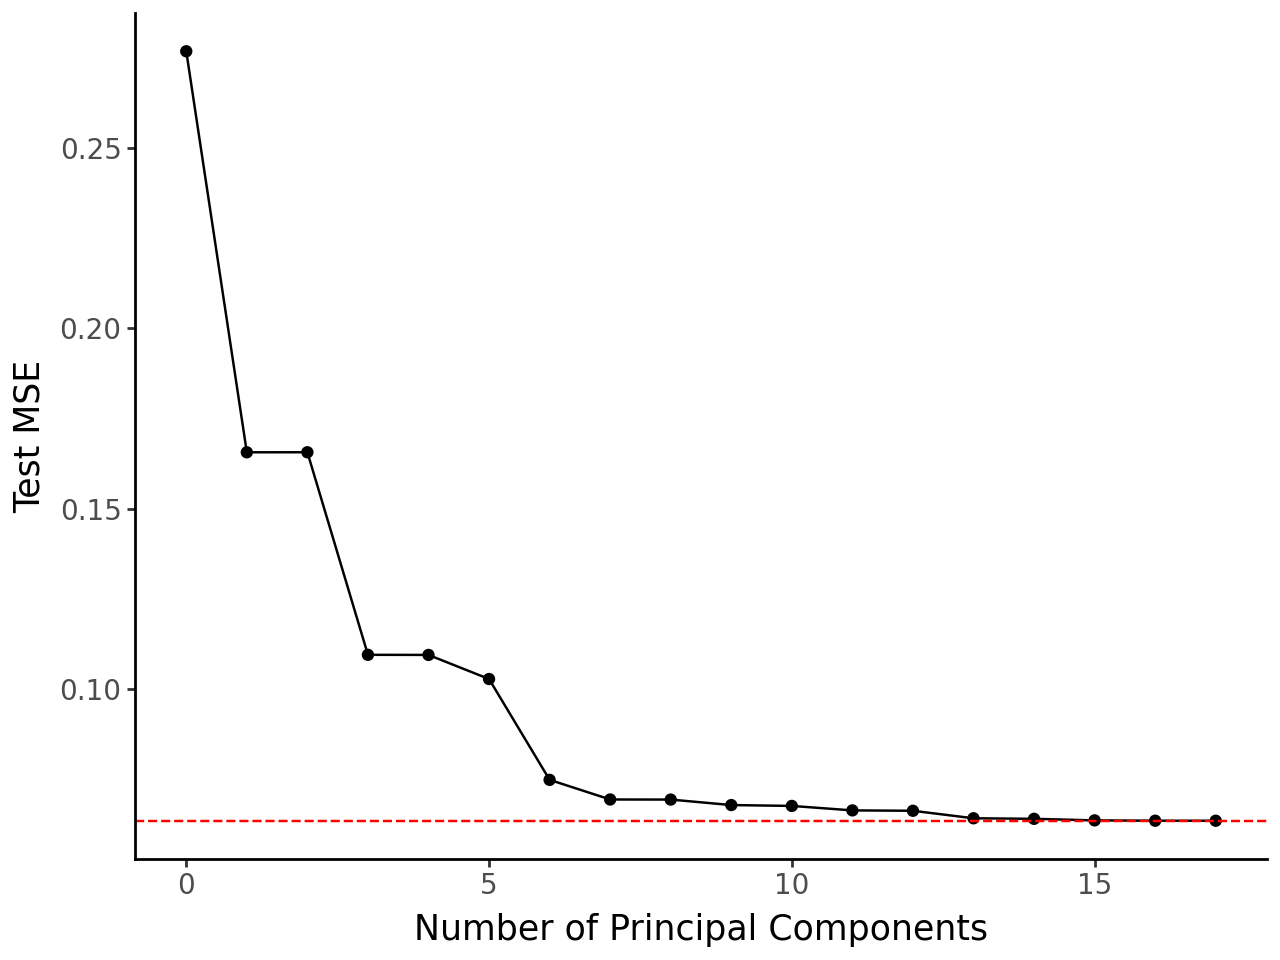

In [ ]:
# Principal Components Regression implementation
pca = PCA()
lm = LinearRegression()
x_transformed = pca.fit_transform(scale(x_train))
n = len(x_transformed)

# Cross-validation for component selection
folds2 = KFold(n_splits = 10, shuffle = True, random_state = 35)
pcr_mse = []

# Calculate MSE for the intercept
pcr_intercept = -1*cross_val_score(lm, np.ones((n, 1)), y_train, cv = folds2,
                                   scoring = 'neg_mean_squared_error').mean()
pcr_mse.append(pcr_intercept)

# Calculate MSE for each number of components
for i in range(1, 18, 1):
    pcr_value = -1*cross_val_score(lm, x_transformed[:, :i], y_train,
                                   cv = folds2,
                                   scoring = 'neg_mean_squared_error').mean()
    pcr_mse.append(pcr_value)

# Visualization of component selection
pcr_mse = pd.DataFrame(pcr_mse)
plot_pcr_cv_theme = theme(axis_title = element_text(size = 12.5),
                          axis_text = element_text(size = 10))
plot_pcr_cv = (ggplot(data = pcr_mse,
                      mapping = aes(x = np.array(range(0, 18, 1)),
                                    y = pcr_mse.iloc[:, 0]
)) +
  geom_point() +
  geom_line() +
  geom_hline(yintercept = min(pcr_mse[0]), linetype = 'dashed',
             colour = 'red') +
  theme_classic() +
  xlab('Number of Principal Components') +
  ylab('Test MSE') +
  plot_pcr_cv_theme
)
plot_pcr_cv

PCR with all 17 components achieves a test MSE of 0.0623, slightly better than best subset selection but not quite as good as ridge regression. The cross-validation suggests that all components contribute to predictive performance.

In [ ]:
# transform test data
x_transformed_test = pca.transform(scale(x_test))[:, :18]
# train on training data
lm = LinearRegression()
lm.fit(x_transformed[:, :18], y_train)
# test on test data
pcr_predictions = lm.predict(x_transformed_test)
print(mean_squared_error(y_test, pcr_predictions))

# add test MSE to matrix
model_stats.loc['PCR', 'Test MSE'] = mean_squared_error(y_test, pcr_predictions)

0.062278200502647256


A test set MSE of 0.0623 is the second best so far.

#### 3.4.2 Partial Least Squares (PLS)



Partial least squares (PLS) is also a dimension reduction techinque. PCR was an unsupervised approach - the response was not used to help determine the principal component directions. So, the directions might have explained the predictors but those directions are not necessarily the best directions for predicting the response.

PLS overcomes this as a supervised approach by utilising the response to identify components that explain the predictors and the response. Once again, the number of components can be determined using cross-validation.

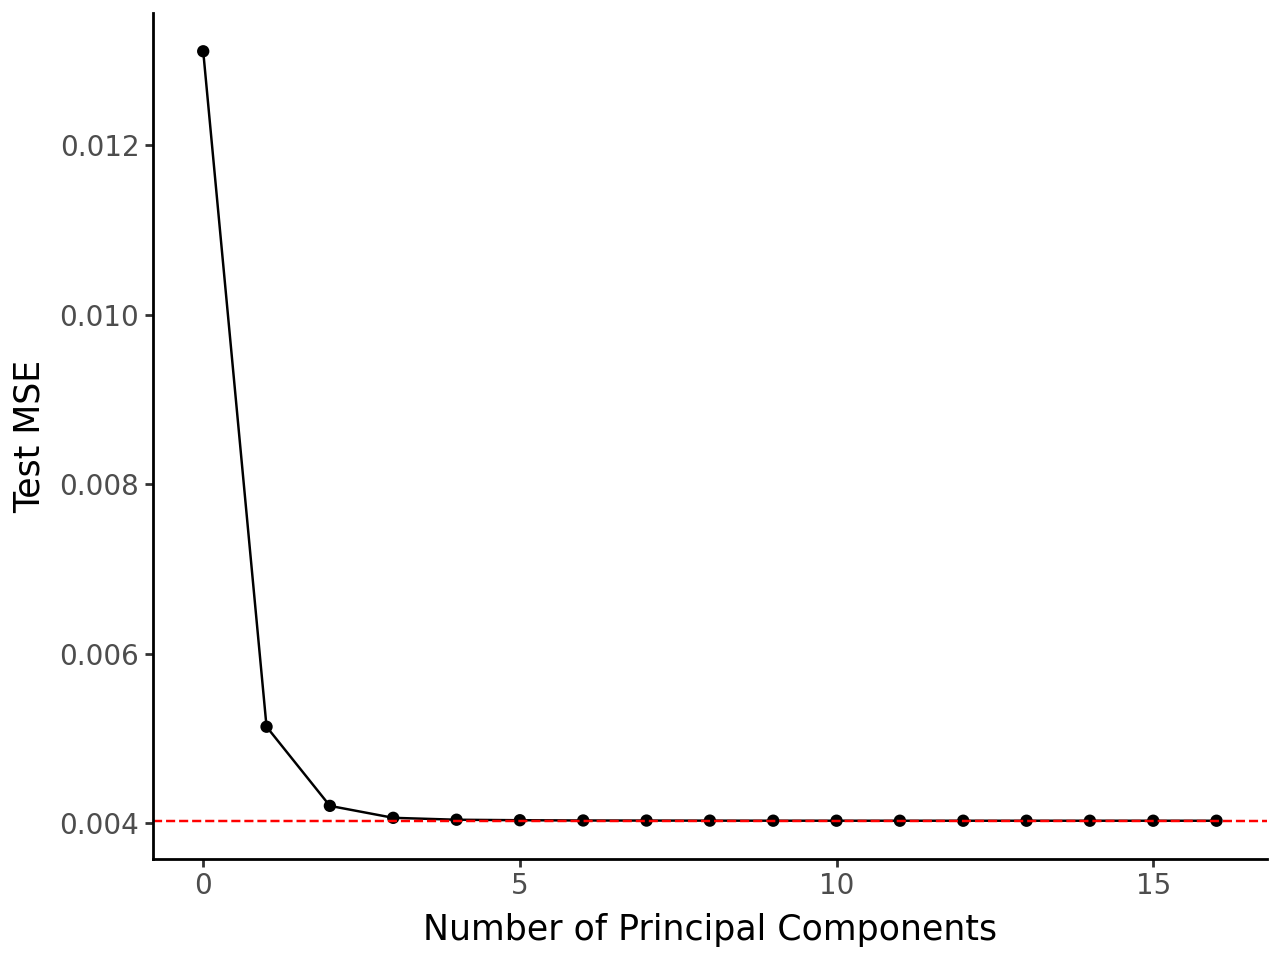

In [ ]:
# Partial Least Squares implementation
folds2 = KFold(n_splits = 10, shuffle = True, random_state = 35)
pls_mse = []

for i in range(1, 18, 1):
    pls = PLSRegression(n_components = i)
    pls_value = cross_val_score(pls, scale(x_train), y_train, cv = folds2,
                                scoring = 'neg_mean_squared_error').mean()
    pls_mse.append(pls_value)

# Visualization of component selection
pls_mse = pd.DataFrame(pls_mse)
pls_mse[0] = pls_mse[0]**2
plot_pls_cv_theme = theme(axis_title = element_text(size = 12.5),
                          axis_text = element_text(size = 10))
plot_pls_cv = (ggplot(data = pls_mse,
                      mapping = aes(x = np.array(range(0, 17, 1)),
                                    y = pls_mse.iloc[:, 0]
)) +
  geom_point() +
  geom_line() +
  geom_hline(yintercept = min(pls_mse[0]), linetype = 'dashed',
             colour = 'red') +
  theme_classic() +
  xlab('Number of Principal Components') +
  ylab('Test MSE') +
  plot_pls_cv_theme
)
plot_pls_cv

While the lowest cross-validation error is achieved with all 17 components, performance stabilizes after approximately 4 components. Using a more parsimonious 4-component PLS model yields a test MSE of 0.0623, matching PCR performance with significantly fewer components.

In [ ]:
pls = PLSRegression(n_components = 4)
pls.fit(scale(x_train), y_train)
print(mean_squared_error(y_test, pls.predict(scale(x_test))))

# add test MSE to matrix
model_stats.loc['PLS', 'Test MSE'] = mean_squared_error(
    y_test, pls.predict(scale(x_test))
    )

0.06227737644908609


This test set MSE is almost identical to PCR, but is slightly better and therefore becomes the second best so far:

In [ ]:
model_stats

,Test MSE
Best subset selection,0.063517
Forward stepwise selection,0.065554
Backward stepwise selection,0.065554
Ridge regression,0.061973
Lasso regression,NaN
PCR,0.062278
PLS,0.062277
Single regression tree,NaN
Bagging,NaN
Random forest,NaN


### 3.5 Linear Models Comparison

In [ ]:
# Comparison of linear model approaches
model_stats.iloc[:7]

,Test MSE
Best subset selection,0.063517
Forward stepwise selection,0.065554
Backward stepwise selection,0.065554
Ridge regression,0.061973
Lasso regression,NaN
PCR,0.062278
PLS,0.062277



Among linear approaches, ridge regression performs best (MSE: 0.0620), followed by PCR and PLS (both MSE: 0.0623). The subset selection methods perform slightly worse, with best subset selection (MSE: 0.0635) outperforming forward and backward stepwise selection (both MSE: 0.0660).

## 4. Tree-based Approaches

Tree-based methods involve segmenting the predictor space into separate regions. By following the ‘rules’ at each internal node, you will end up at a terminal node corresponding to a particular region. The prediction is the mean (or sometimes median) value for that region. See my [R version](https://www.kaggle.com/thwaiteso/advanced-regression-techniques-r) for a good illustration.

### 4.1 Single Regression Tree

Let's see how a single regression tree performs. 'ccp_alpha' is the complexity parameter used to determine whether the tree needs pruning. I will use cross-validation to choose the best alpha from a range. I have capped the tree at a maximum depth of three because when left to be as complex as it likes, the resulting plot of the tree is illegible:

<ipython-input-40-9f9f39783c1c>:28: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead


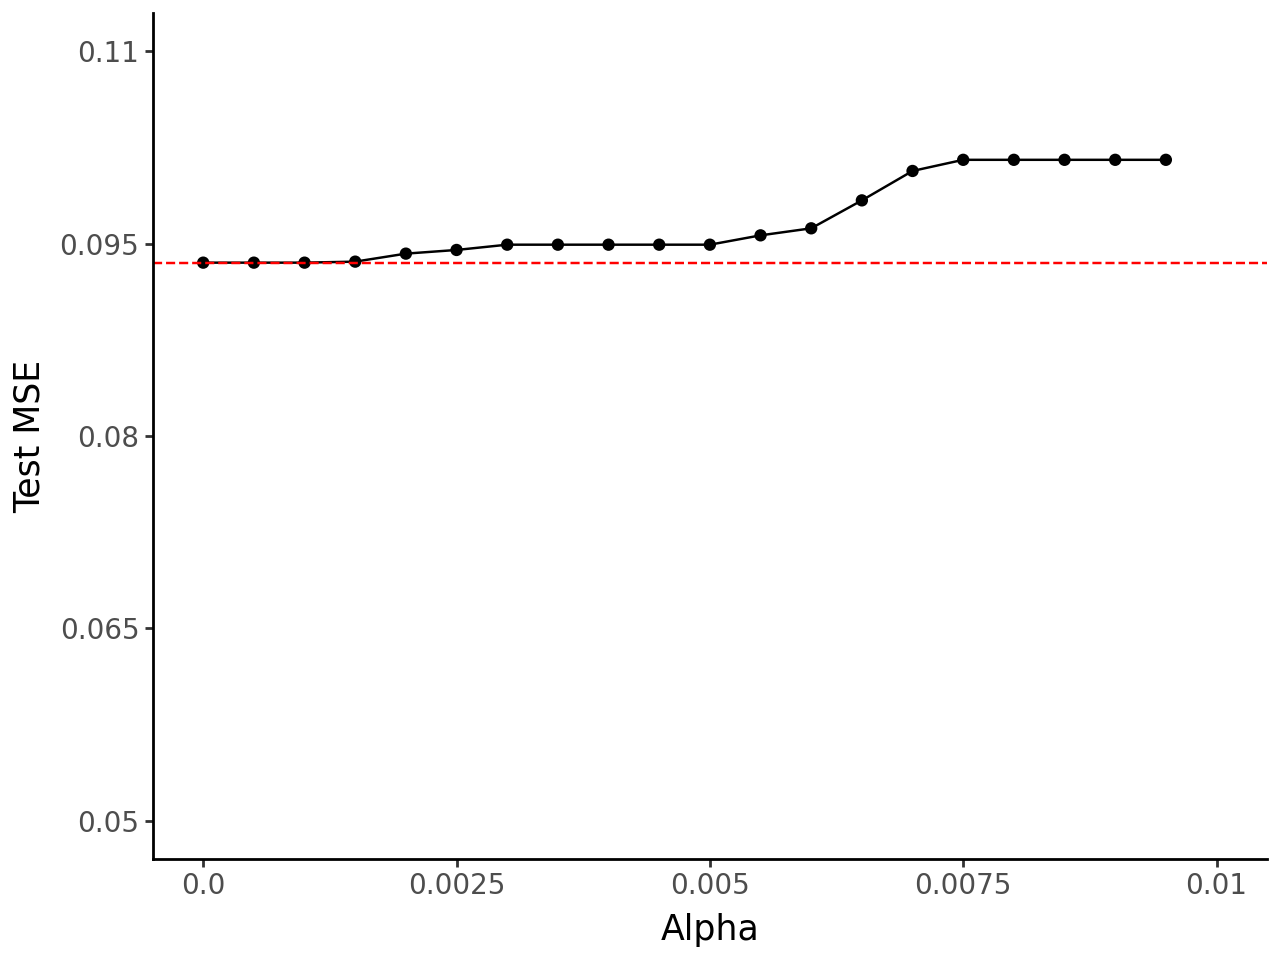

In [ ]:
# Cross-validation for complexity parameter (alpha)
ccp_alphas = np.array(list(np.arange(0, 0.01, 0.0005)), dtype = 'float64')
single_tree_stats = pd.DataFrame(columns = ccp_alphas, index = list(range(1, 11, 1)))

# Implement cross-validation
for i in range(1, k + 1):
    x_train_fold = x[folds != (i - 1)]
    y_train_fold = y[folds != (i - 1)]
    x_test_fold = x[folds == (i - 1)]
    y_test_fold = y[folds == (i - 1)]

    for ccp_alpha in ccp_alphas:
        tree = DecisionTreeRegressor(random_state = 35, max_depth = 3, ccp_alpha = ccp_alpha)
        tree.fit(x_train_fold, y_train_fold)
        tree_predict = tree.predict(x_test_fold)
        tree_test_mse = mean_squared_error(y_test_fold, tree_predict)
        single_tree_stats.loc[i, ccp_alpha] = tree_test_mse

# Visualization of alpha selection
tree_mean = single_tree_stats.apply(np.mean, axis = 0)
plot_tree_cv_theme = theme(axis_title = element_text(size = 12.5),
                           axis_text = element_text(size = 10))
plot_tree_cv = (ggplot(data = pd.DataFrame(tree_mean),
                      mapping = aes(x = ccp_alphas,
                                    y = tree_mean)) +
  geom_point() +
  geom_line() +
  geom_hline(yintercept = min(tree_mean[0:]), linetype = 'dashed',
             colour = 'red') +
  theme_classic() +
  xlab('Alpha') +
  ylab('Test MSE') +
  plot_tree_cv_theme +
  scale_x_continuous(breaks = np.array(np.arange(0, 0.0125, 0.0025)),
                     labels = np.array(np.arange(0, 0.0125, 0.0025)),
                     limits = np.array([0, 0.01])) +
  scale_y_continuous(breaks = np.array(np.linspace(0.05, 0.11, 5)),
                     labels = np.array(np.linspace(0.05, 0.11, 5)),
                     limits = np.array([0.05, 0.11]))
)
plot_tree_cv

The best test set MSE was found with an alpha of 0, 0.0005 or 0.001. I will select 0, this means the tree is not pruned at all. When fitting a tree with alpha = 0 to all the training data I will once again cap its depth at three.

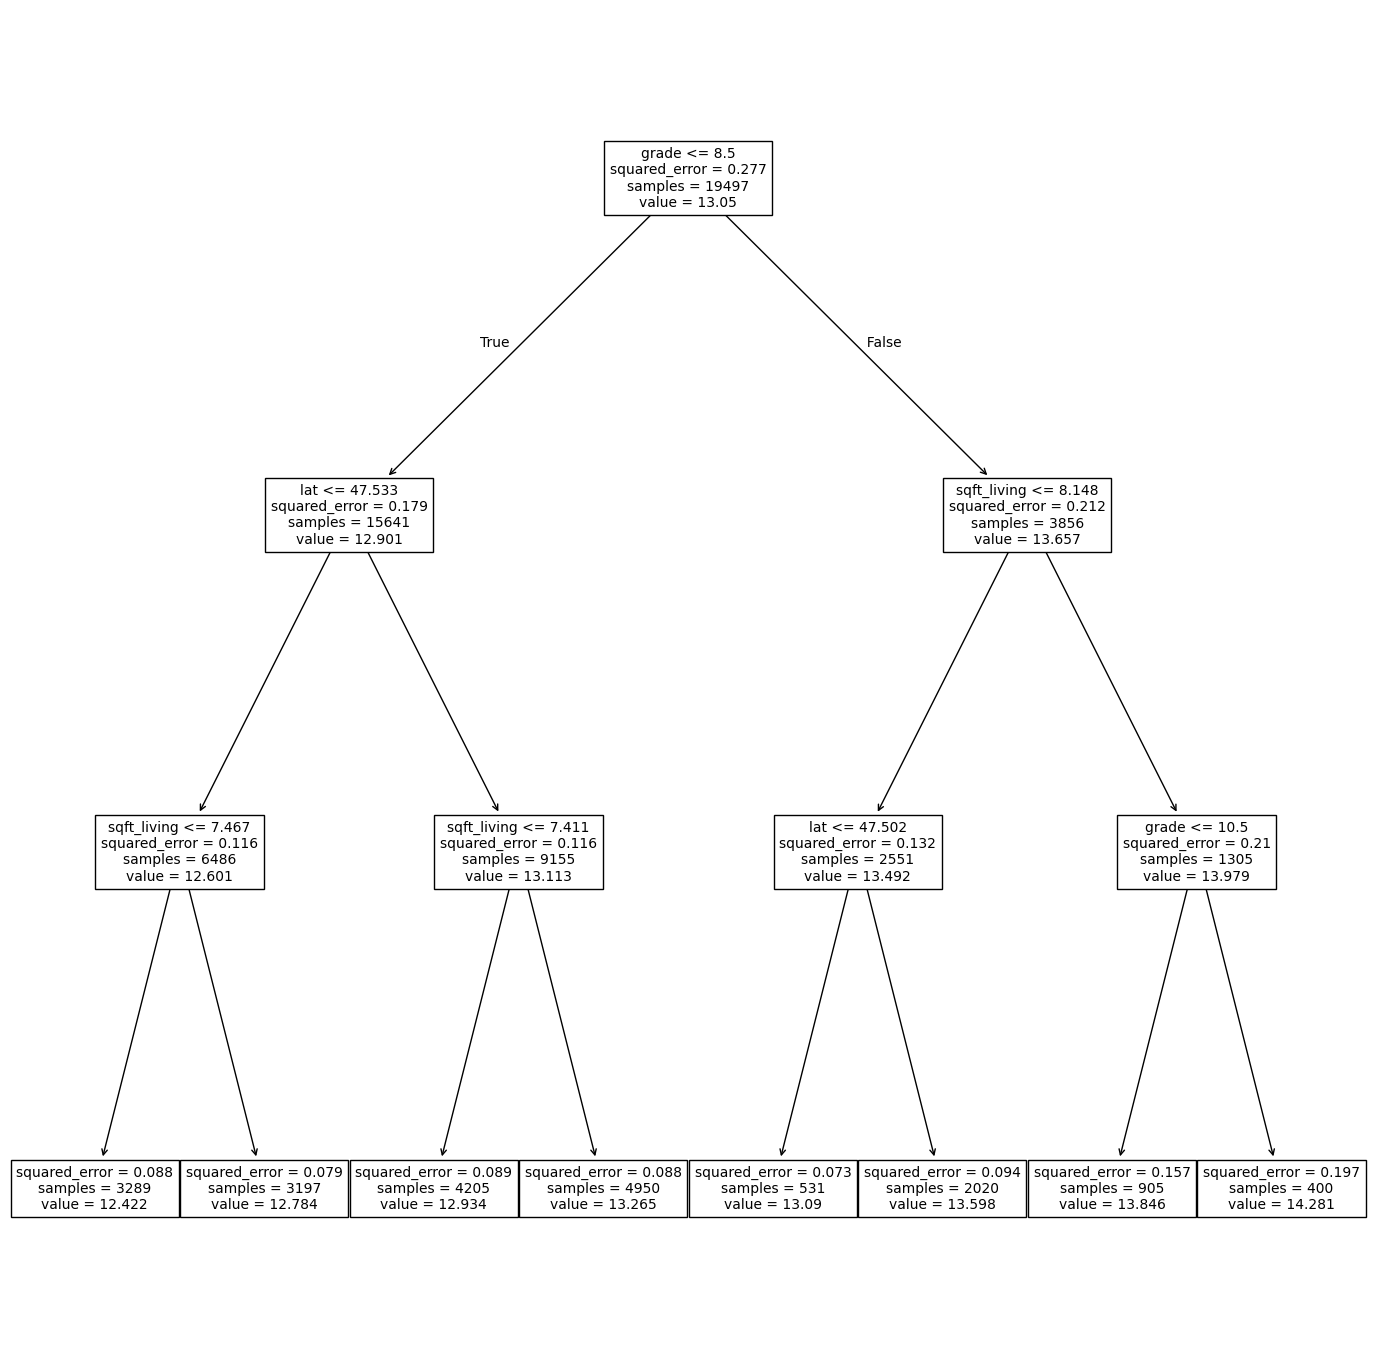

In [ ]:
# fit a tree to all training data - again going to use a max depth of 5
# i have tried using everything default, but the tree is massive and illegible
single_tree = DecisionTreeRegressor(random_state = 35, max_depth = 3,
                                    ccp_alpha = 0)

# fit to training values
single_tree.fit(x_train, y_train)
# create predictions using test set
single_tree_predict = single_tree.predict(x_test)
# calculate test set MSE
single_tree_test_mse = mean_squared_error(y_test, single_tree_predict)
fig, ax = plt.subplots(figsize = (17.5, 17.5))
plot_tree(single_tree, fontsize = 10, ax = ax, feature_names = x_train.columns)
plt.show()

You can see a number of internal nodes used to split the data, starting with determining if the grade of the house is below or above 8.5. The number of (training) samples in each node is shown. The predictions ('value = ') are the house prices which were log-transformed - for reference 12.5 is 268,337.30, 13 is 442,413.40, 13.5 is 729,416.40 and 14 is 1,202,604.

So, how does the performance of this single tree stack up against the previous models?

In [ ]:
# add test MSE to matrix
model_stats.loc['Single regression tree', 'Test MSE'] = single_tree_test_mse
model_stats

,Test MSE
Best subset selection,0.063517
Forward stepwise selection,0.065554
Backward stepwise selection,0.065554
Ridge regression,0.061973
Lasso regression,NaN
PCR,0.062278
PLS,0.062277
Single regression tree,0.092909
Bagging,NaN
Random forest,NaN


This single tree is the worst method so far. Fortunately, there are other methods that aggregate many trees to increase the predictive performance.

### 4.2 Bagging (Bootstrap Aggregation)


‘Bagging’, aka bootstrap aggregation, is used to reduce the variance of a model. Bootstrapping is an approach where you take repeated samples from the same (training) data set. You train your model on each bootstrapped training set, and average their predictions.

In the context of trees, you can construct a tree for each bootstrapped training set and average their predictions. The trees are deep and unpruned - each tree therefore has high variance and low bias, but by averaging the trees you reduce the variance.

In [ ]:
# Bagging implementation (random forest with max_features = total features)
bag_model = RandomForestRegressor(max_features = 17, random_state = 35)
bag_model.fit(x_train, y_train.values.ravel())
bag_predict = bag_model.predict(x_test)
bag_test_set_mse = mean_squared_error(y_test, bag_predict)
print(f"Bagging test MSE: {bag_test_set_mse:.5f}")

Bagging test MSE: 0.03086


Bagging dramatically improves performance over a single tree, achieving a test MSE of 0.0300 - approximately half the error of the best linear method.

In [ ]:
# add test MSE to matrix
model_stats.loc['Bagging', 'Test MSE'] = bag_test_set_mse

### 4.3 Random Forest


A random forest is similar to bagging, in that a tree is fit to each bootstrapped training set. However, where bagging considers every variable when making a split, a random forest only considers a *random subset* of the predictors. This may sound counter-intuitive - why would you not want to consider every variable at each split?

If you have one very strong predictor, it is highly likely that in bagging this variable will be responsible for the first split in almost every tree - therefore the trees will look quite similar and the predictions from them will be highly correlated. Even by averaging these correlated predictions, the variance reduction is not as large as averaging uncorrelated predctions. This is where random forest steps in - by considering a (random) subset of predictors at each split, the trees will be *decorrelated* where all predictors are given more of a chance.

The number of predictors in each subset is therefore a factor to consider, but I will use the default value is this analysis, which is five in this case.

By using a subset of predictors at each split, you can determine which variables are more important in predicting the response:

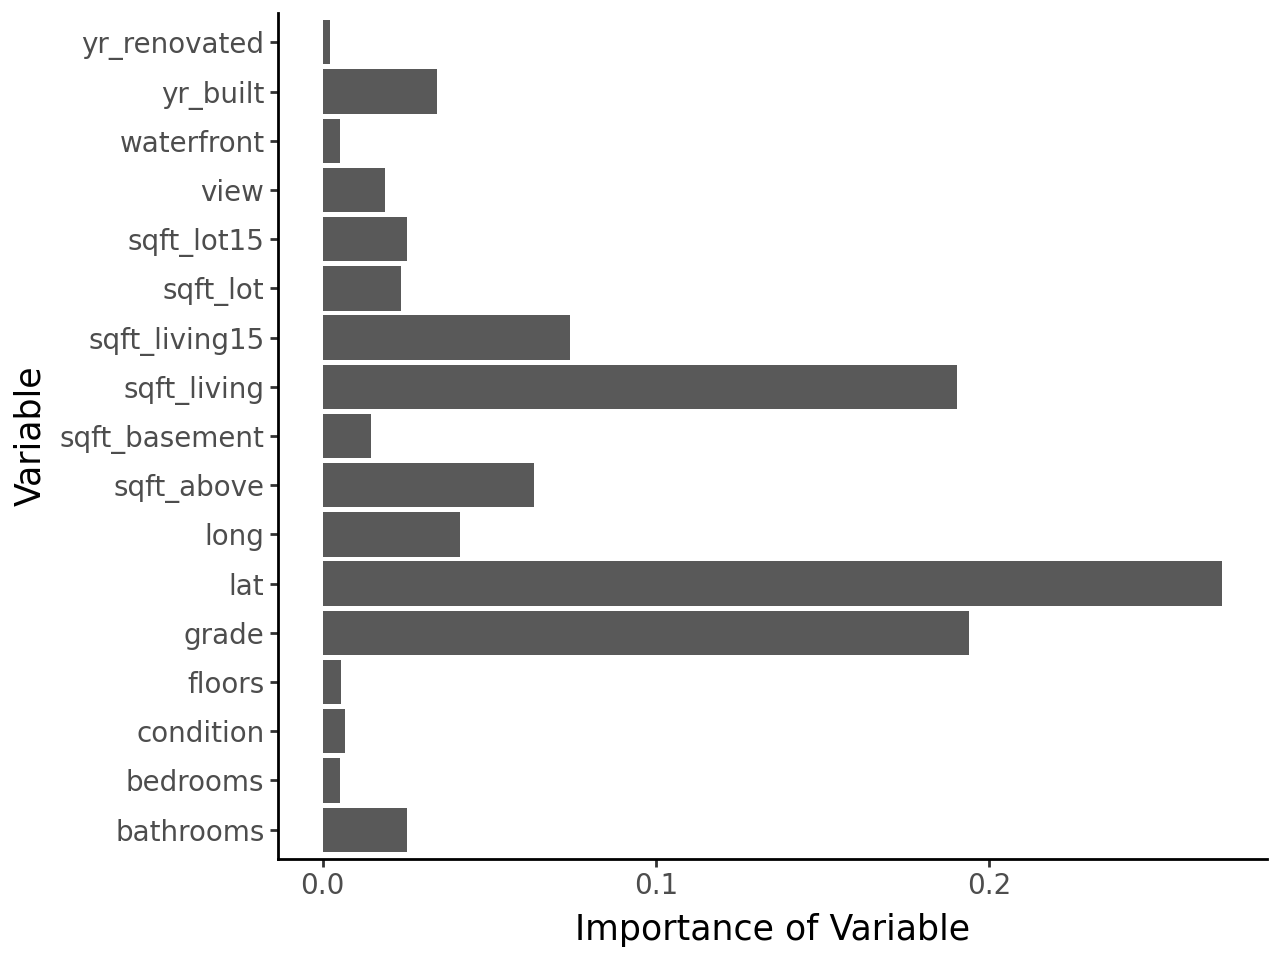

In [ ]:
# Random forest implementation
rf_model = RandomForestRegressor(max_features = 5, random_state = 35)
rf_model.fit(x_train, y_train.values.ravel())

# Variable importance
rf_var_importance = pd.DataFrame({'Importance': rf_model.feature_importances_},
                                 index = x_train.columns)
plot_rf_var_importance_theme = theme(axis_title = element_text(size = 12.5),
                                     axis_text = element_text(size = 10))
plot_rf_var_importance = (ggplot(data = rf_var_importance,
                                 mapping = aes(x = rf_var_importance.index,
                                               y = rf_var_importance['Importance'])) +
  geom_col() +
  theme_classic() +
  xlab('Variable') +
  ylab('Importance of Variable') +
  plot_rf_var_importance_theme +
  coord_flip()
)
plot_rf_var_importance

The plot shows that latitude is by far the most important variable with the grade of the house and the square footage of the living area rounding out the top tree.

That’s all well and good, but is random forest an improvement over bagging?

In [ ]:
# make predictions using test data
rf_predict = rf_model.predict(x_test)
# calculate test set MSE
rf_test_set_mse = mean_squared_error(y_test, rf_predict)
print(rf_test_set_mse)

# add test MSE to matrix
model_stats.loc['Random forest', 'Test MSE'] = rf_test_set_mse

0.03104658909073637


Random forest is slightly worse than bagging but is still far superior to the linear model approaches.

### 4.4 Boosting


In boosting, trees are grown slowly using information from previously grown trees, unlike bagging where trees are grown independently. Boosting does not utilse bootstrap sampling.

There are a number of parameters that can be changed to tune the performance:
1. The shrinkage paramater (λ) - this is the rate at which boosting learns
2. The depth of the tree
3. The minimum number of observations needed in a node
4. The ‘bag.fraction’ paramater allowing stochastic gradient descent. In this approach, there is a global minimum of the loss function. If the loss function is U-shaped, it is not that difficult to find that minimum. However, if it shaped differently, the global minimum might be behind multiple local minimums which the algorithm would normally stop at. Stochastic gradient descent means a subset of the training data is used to grow a tree, a different subset for the bext tree, and so on. This increases the speed of running this algorithm, and while it doesn’t guarantee the global minimum can be found it does make it more likely that local minimums and plateaus can be overcome.

Therefore, I will use a number of different values for each parameter:

In [ ]:
# create a dictionary for the different values for the different parameters
parameters = {'Learning rate': [0.001, 0.01, 0.1],
              'Depth': [1, 2, 3, 4, 5],
              'Min. Node Obs.': [5, 10, 15],
              'Bag fraction': [0.65, 0.8, 1]}

# ParameterGrid creates dictionaries for each of the different combinations
# of parameters
parameter_grid = ParameterGrid(parameters)

# dataframe to track test MSE
boost_stats = pd.DataFrame(columns = ['Test MSE'])

I'll then perform boosting, fitting a model to each combination of predictors:

In [ ]:
# iterate over each combination of parameters
for i in range(1, len(list(parameter_grid))):

    # create boosted model using parameters at i
    boost_model = GradientBoostingRegressor(
        learning_rate = list(parameter_grid)[i]['Learning rate'],
        subsample = list(parameter_grid)[i]['Bag fraction'], # enables
        # stochastic gradient boosting
        min_samples_leaf = list(parameter_grid)[i]['Min. Node Obs.'],
        max_depth = list(parameter_grid)[i]['Depth'],
        random_state = 35
        )

    # fit to training data
    boost_model.fit(x_train, y_train.values.ravel())
    # predict using training data
    boost_predict = boost_model.predict(x_test)
    # calculate test set MSE
    boost_test_set_mse = mean_squared_error(y_test, boost_predict)
    # add to dataframe
    boost_stats.loc[i, 'Test MSE'] = boost_test_set_mse

print('Lowest test set MSE is', min(boost_stats['Test MSE']))
# this was the last model used, which had the following parameters
print('The best model had these parameters:', list(parameter_grid)[134])
# won't be repeating this by using different parameters, but shown it can be
# in R and is possible if a bit trickier in python

Lowest test set MSE is 0.02715817381676151
The best model had these parameters: {'Bag fraction': 1, 'Depth': 5, 'Learning rate': 0.1, 'Min. Node Obs.': 15}


You could keep on fine-tuning the parameters almost indefinitely, but I will stop for now. I will take the best model and add it to the matix.

In [ ]:
# add test MSE to matrix
model_stats.loc['Boosting', 'Test MSE'] = min(boost_stats['Test MSE'])

## 5. Conclusion

### 5.1 Model Performance Comparison


I’ll recap what I’ve done in this analysis:  
1) I used 11 different methods to predict house prices, seven based on the linear model and four tree-based methods  
2) For each method, models were fit to training data, with some type of validation used to determine what the best model was  
3) The best model for a given method was then tested on a test set, with the resulting MSE placed in a matrix  
4) The matrix allows all of these models to be compared, with the results outlined below:

In [ ]:
# Final comparison of all models
model_stats

,Test MSE
Best subset selection,0.063517
Forward stepwise selection,0.065554
Backward stepwise selection,0.065554
Ridge regression,0.061973
Lasso regression,NaN
PCR,0.062278
PLS,0.062277
Single regression tree,0.092909
Bagging,0.03086
Random forest,0.031047


The worst models with the highest test MSEs were the single regression tree, followed by forward and backward stepwise selection. Lasso regression comes next, followed by best subset selection. PLS is the best of the linear model methods beating ridge regression which comes second. The best models were the remaining tree-based methods, boosting is the best model with a notable improvement over second-placed random forest and a substantial decrease in test MSE compared to the worst models.

The tree-based approaches also highlighted that latitude was the most significant predictor, followed by the square footage of the house and the grade of the house, and to a lesser extent longitude. This confirmed my early thoughts based on the exploratory data analysis in section 2.



### 5.2 Key Price Determinants


Random forest variable importance and exploratory analysis consistently identify the following as key housing price determinants:

1. **Location** - latitude is the most important predictor, with northern areas and waterfront proximity commanding premium prices
2. **Quality** - grade (construction quality and design) is highly influential
3. **Size** - living area square footage is a strong predictor, while lot size is less important
4. **Neighborhood context** - the characteristics of surrounding properties affect value

### 5.3 Practical Implications


For real estate professionals, home buyers, and sellers, this analysis provides several actionable insights:

1. **Location remains paramount** - homes in the northern parts of King County near water bodies command significant premiums
2. **Construction quality matters** - investing in higher-grade construction and design provides substantial returns
3. **Size efficiency** - living space appears more valuable than lot size in this market
4. **Neighborhood effects** - property values are influenced by surrounding properties, particularly their size and quality

For predictive modeling, the superior performance of tree-based ensembles suggests that the relationship between housing features and price is complex and nonlinear, requiring flexible modeling approaches to capture accurately.

### 5.4 Future Work



Potential extensions to this analysis could include:

1. Incorporating additional data sources (school quality, crime rates, walkability scores)
2. Developing spatially explicit models that better account for neighborhood effects
3. Creating specialized models for different market segments (luxury homes, condos, etc.)
4. Implementing time series analysis to capture market trends and seasonality
5. Exploring deep learning approaches for extremely complex feature interactions

This project demonstrates the power of modern statistical learning techniques in real estate valuation, providing a foundation for more accurate price predictions and deeper market insights.